# Model 1 - circular fingerprint features 1024 - H20 autoML - Model Interpretation



## 🛡️ Data Leakage Prevention - CRITICAL FIXES

**This notebook has been updated to prevent data leakage using:**

1. ✅ **Scaffold-based splitting** (not random!)
2. ✅ **Duplicate removal BEFORE splitting**
3. ✅ **Near-duplicate detection** (Tanimoto ≥ 0.95)
4. ✅ **Feature scaling on train only**
5. ✅ **Proper cross-validation** (scaffold-based)
6. ✅ **Similarity analysis** (train-test)
7. ✅ **Applicability domain** estimation

**Key Changes:**
- Random K-Fold → Scaffold-based splitting
- StandardScaler fitted on training data only
- Complete verification of no SMILES overlap

---

In [ ]:
# Import data leakage prevention utilities
import sys
import warnings
warnings.filterwarnings('ignore')

# Import custom utilities for data leakage prevention
from qsar_utils_no_leakage import (
    QSARDataProcessor,
    ScaffoldSplitter,
    plot_similarity_distribution,
    print_leakage_prevention_summary
)

print("✅ Data leakage prevention utilities loaded successfully!")
print("\n" + "="*70)
print_leakage_prevention_summary()

In [ ]:
#!git clone https://github.com/swansonk14/admet_ai.git
#%cd admet_ai


In [2]:
#!pip install -r requirements.txt
#!pip install -e .

In [3]:
#from admet_ai import ADMETModel

#model = ADMETModel()
#preds = model.predict(smiles="O(c1ccc(cc1)CCOC)CC(O)CNC(C)C")

In [4]:
#preds

## Data loading and Preprocessing



In [ ]:
import multiprocessing

print("Number of CPU cores:", multiprocessing.cpu_count())

Number of CPU cores: 2


In [ ]:
# For Reporducibility
import numpy as np
np.random.seed(42)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load dataset
import pandas as pd
df=pd.read_excel('/content/drive/MyDrive/DrRoyRationalDesign/Input of triazole and cysteine_datasheet.xlsx')
df

,Identifier,Canonical SMILES,IC50 uM,PIC50
0,TB-VS0012,CCCCCCC#CC1=CC(C2=NN=C(SCC3=CC=C(Cl)C=C3)N2C)=...,5.3,5.275724
1,TB-VS12-2,BrC1=CC(C2=NN=C(N2C)S)=CN=C1,200,3.698970
2,TB-VS12-3,BrC1=CC(C2=NN=C(N2C)SCC3=CC=C(C=C3)Cl)=CN=C1,200,3.698970
3,TB-VS12-4,CCCCCCC#CC1=CC(C2=NN=C(N2C)S)=CN=C1,22.57,4.646468
4,TB-VS12-5,CCCCCCC#CC1=CC(C2=NN=C(SCC3=CC=CC=C3)N2C)=CN=C1,175,3.756962
...,...,...,...,...
185,ROY-0000225-001,CC(OC(N1CC(OCCCC2=CC=CC=C2)C1)=O)(C)C,148,3.829738
186,ROY-0000224-001,CCCCCCOC(C1)CN1C(OC(C)(C)C)=O,>200,NaN
187,ROY-0000177-001,BrC1=CC(C#CC2=CC=CC=C2)=CN=C1,>200,NaN
188,ROY-0000176-001,FC(F)(F)OC(C=C1)=CC=C1C#CC2=CN=CC(Br)=C2,>200,NaN


In [ ]:
pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 23.0 MB/s eta 0:00:00


In [ ]:
# ✅ FIXED: Proper duplicate handling to prevent leakage
import pandas as pd
from rdkit import Chem

print(f"📊 Original dataset: {len(df)} rows")

# Initialize the QSAR data processor
processor = QSARDataProcessor(smiles_col='Canonical SMILES', target_col='IC50 uM')

# Step 1: Canonicalize SMILES (ensures consistency)
df = processor.canonicalize_smiles(df)

# Step 2: Remove exact duplicates BEFORE splitting (prevents leakage!)
# Strategy 'average' will average replicate measurements
df = processor.remove_duplicates(df, strategy='average')

print(f"\n✅ Clean dataset ready: {len(df)} unique molecules")

# Keep this for backward compatibility with existing code
unique_df = df.copy()
numeric_df = df.copy()

Duplicate molecules found:
     Identifier                                   Canonical SMILES IC50 uM  \
138   TB-LCA-33  ClC1=CC=C(CS(C[C@H](N)C(NC(C=C2)=CC=C2C3=CC=CC...     200   
147   TB-LCA-34  ClC1=CC=C(CS(C[C@H](N)C(NC(C=C2)=CC=C2C3=CC=CC...     200   
90   TB-VS12-97  O=C1NC(C=CN1[C@@H]2O[C@H](CSC3=NN=C(C4=CC(C#CC...   97.71   
94   TB-VS12-97  O=C1NC(C=CN1[C@@H]2O[C@H](CSC3=NN=C(C4=CC(C#CC...   97.71   

        PIC50  
138  3.698970  
147  3.698970  
90   4.010061  
94   4.010061  


In [11]:
unique_df

,Identifier,Canonical SMILES,IC50 uM,PIC50
0,TB-VS0012,CCCCCCC#CC1=CC(C2=NN=C(SCC3=CC=C(Cl)C=C3)N2C)=...,5.3,5.275724
1,TB-VS12-2,BrC1=CC(C2=NN=C(N2C)S)=CN=C1,200,3.698970
2,TB-VS12-3,BrC1=CC(C2=NN=C(N2C)SCC3=CC=C(C=C3)Cl)=CN=C1,200,3.698970
3,TB-VS12-4,CCCCCCC#CC1=CC(C2=NN=C(N2C)S)=CN=C1,22.57,4.646468
4,TB-VS12-5,CCCCCCC#CC1=CC(C2=NN=C(SCC3=CC=CC=C3)N2C)=CN=C1,175,3.756962
...,...,...,...,...
185,ROY-0000225-001,CC(OC(N1CC(OCCCC2=CC=CC=C2)C1)=O)(C)C,148,3.829738
186,ROY-0000224-001,CCCCCCOC(C1)CN1C(OC(C)(C)C)=O,>200,NaN
187,ROY-0000177-001,BrC1=CC(C#CC2=CC=CC=C2)=CN=C1,>200,NaN
188,ROY-0000176-001,FC(F)(F)OC(C=C1)=CC=C1C#CC2=CN=CC(Br)=C2,>200,NaN


In [12]:
unique_df['IC50 uM'].value_counts()

,count
IC50 uM,
200,35
>200,5
250,4
100,3
25.12,2
...,...
6.843,1
5.615,1
9.705,1


In [13]:
unique_df['IC50 uM'].isna().sum()


np.int64(6)

In [ ]:
# Keep only rows where IC50 uM is numeric
mask = pd.to_numeric(df["IC50 uM"], errors="coerce").notna()
df = df[mask].reset_index(drop=True)

print(f"✅ Final clean dataset: {len(df)} molecules with valid IC50 values")

# Keep for backward compatibility
numeric_df = df.copy()

In [15]:
numeric_df

,Identifier,Canonical SMILES,IC50 uM,PIC50
0,TB-VS0012,CCCCCCC#CC1=CC(C2=NN=C(SCC3=CC=C(Cl)C=C3)N2C)=...,5.3,5.275724
1,TB-VS12-2,BrC1=CC(C2=NN=C(N2C)S)=CN=C1,200,3.698970
2,TB-VS12-3,BrC1=CC(C2=NN=C(N2C)SCC3=CC=C(C=C3)Cl)=CN=C1,200,3.698970
3,TB-VS12-4,CCCCCCC#CC1=CC(C2=NN=C(N2C)S)=CN=C1,22.57,4.646468
4,TB-VS12-5,CCCCCCC#CC1=CC(C2=NN=C(SCC3=CC=CC=C3)N2C)=CN=C1,175,3.756962
...,...,...,...,...
181,ROY-0000175-001,CC(OC(N(C1)CC21CCN(C3=CC(C#CC4=CC=CC=C4)=CN=C3...,6.843,5.164753
183,ROY-0000223-001,ClC(C=C1)=CC=C1CO[C@H](CC2)CN2C3=CC(C#CC4=CC=C...,5.615,5.250650
184,ROY-0000222-001,ClC(C=C1)=CC=C1CO[C@H](CC2)CN2C3=CC(C#CC4=CC=C...,9.705,5.013004
185,ROY-0000225-001,CC(OC(N1CC(OCCCC2=CC=CC=C2)C1)=O)(C)C,148,3.829738


# Standarization

/tmp/ipython-input-1330070655.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_df[col] = numeric_df[col].astype(str).str.replace(">", "", regex=False)
/tmp/ipython-input-1330070655.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_df[col] = numeric_df[col].astype(str).str.replace("<", "", regex=False)
/tmp/ipython-input-1330070655.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



UNIVARIATE ANALYSIS: IC50 UΜ


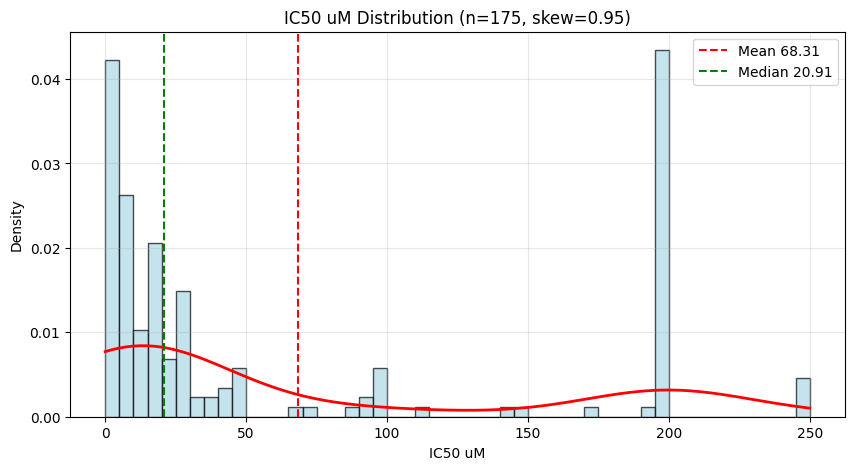

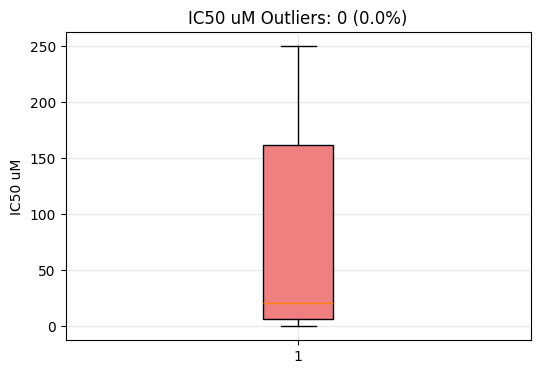


STATISTICAL SUMMARY
   Count    Mean  Median     Std    Min    Max    Range     Q1     Q3  \
0    175  68.306   20.91  82.996  0.048  250.0  249.952  6.373  161.5   

       IQR  Skewness  Kurtosis  Outliers  Outlier %  Normal p-value  \
0  155.128     0.947    -0.865         0        0.0             0.0   

   Likely Normal  
0          False  

INSIGHTS & RECOMMENDATIONS
- Moderately skewed — consider a transform.


In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# Column name
col = "IC50 uM"

# =============================
# CLEAN + CONVERT TO NUMERIC
# =============================
# Remove ">" or "<" signs if present (common in IC50 datasets)
numeric_df[col] = numeric_df[col].astype(str).str.replace(">", "", regex=False)
numeric_df[col] = numeric_df[col].astype(str).str.replace("<", "", regex=False)

# Convert to numeric safely
numeric_df[col] = pd.to_numeric(numeric_df[col], errors='coerce')

# Drop NaNs
data = numeric_df[col].dropna()

print("UNIVARIATE ANALYSIS: IC50 UΜ")
print("="*60)

# =============================
# HISTOGRAM + KDE + MEAN/MEDIAN
# =============================
plt.figure(figsize=(10,5))

# Histogram
plt.hist(data, bins=50, density=True, alpha=0.7,
         color='lightblue', edgecolor='black')

# KDE (if enough data)
if len(data) > 10:
    try:
        from scipy.stats import gaussian_kde
        kde = gaussian_kde(data)
        x = np.linspace(data.min(), data.max(), 200)
        plt.plot(x, kde(x), 'r-', linewidth=2)
    except:
        pass

plt.axvline(data.mean(), color='red', linestyle='--', label=f"Mean {data.mean():.2f}")
plt.axvline(data.median(), color='green', linestyle='--', label=f"Median {data.median():.2f}")

plt.title(f"{col} Distribution (n={len(data)}, skew={data.skew():.2f})")
plt.xlabel(col)
plt.ylabel("Density")
plt.grid(alpha=0.3)
plt.legend()
plt.show()

# =============================
# BOX PLOT + OUTLIER ANALYSIS
# =============================
plt.figure(figsize=(6,4))
bp = plt.boxplot(data, patch_artist=True)
bp['boxes'][0].set_facecolor('lightcoral')

Q1, Q3 = data.quantile([0.25, 0.75])
IQR = Q3 - Q1
lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR
outliers = data[(data < lower) | (data > upper)]
out_pct = len(outliers) * 100 / len(data)

plt.title(f"{col} Outliers: {len(outliers)} ({out_pct:.1f}%)")
plt.ylabel(col)
plt.grid(alpha=0.3)
plt.show()

# =============================
# STATISTICAL SUMMARY TABLE
# =============================
print("\nSTATISTICAL SUMMARY")
print("="*60)

row = {
    "Count": len(data),
    "Mean": data.mean(),
    "Median": data.median(),
    "Std": data.std(),
    "Min": data.min(),
    "Max": data.max(),
    "Range": data.max() - data.min(),
    "Q1": Q1,
    "Q3": Q3,
    "IQR": IQR,
    "Skewness": data.skew(),
    "Kurtosis": data.kurtosis(),
    "Outliers": len(outliers),
    "Outlier %": out_pct
}

# Normality test (if enough samples)
if len(data) >= 8:
    stat, p = stats.normaltest(data)
    row["Normal p-value"] = p
    row["Likely Normal"] = p > 0.05
else:
    row["Normal p-value"] = np.nan
    row["Likely Normal"] = "Insufficient data"

summary_df = pd.DataFrame([row])
print(summary_df.round(3))

# =============================
# INSIGHTS & RECOMMENDATIONS
# =============================
print("\nINSIGHTS & RECOMMENDATIONS")
print("="*60)

skew = row["Skewness"]
std = row["Std"]
rng = row["Range"]

recommendations = []

# Skewness
if abs(skew) > 2:
    recommendations.append("Highly skewed — consider log transform.")
elif abs(skew) > 0.5:
    recommendations.append("Moderately skewed — consider a transform.")

# Outlier presence
if out_pct > 10:
    recommendations.append("High outlier rate — consider robust models.")
elif out_pct > 5:
    recommendations.append("Moderate number of outliers — evaluate model impact.")

# Range vs Std
if std > 0 and rng > 100 * std:
    recommendations.append("Very wide dynamic range — consider scaling.")

if not recommendations:
    recommendations.append("Data appears well-behaved.")

for r in recommendations:
    print("-", r)


In [17]:
!pip install deepchem

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 552.4/552.4 kB 21.6 MB/s eta 0:00:00


In [18]:
!pip install umap-learn

In [19]:
numeric_df['Canonical SMILES'].isna().sum()

np.int64(0)

In [20]:
from rdkit import Chem

# Add a column to indicate validity
numeric_df['valid_smiles'] = numeric_df['Canonical SMILES'].apply(lambda s: Chem.MolFromSmiles(s) is not None)

# Print invalid SMILES
invalid_smiles = numeric_df.loc[~numeric_df['valid_smiles'], 'Canonical SMILES']
for idx, s in invalid_smiles.items():
    print(f"Row {idx}: {s}")



Row 68: ClC1=CC=C(CSC[C@H]([NH3]Cl)C(NC2=CC(C#CCCCCCC)=CN=C2)=O)C=C1
Row 69: ClC1=CC=C(CSC[C@H]([NH3]Cl)C(NC2=CC=C(F)C(F)=C2)=O)C=C1
Row 125: ClC1=CC=C(CSC[C@H]([NH3]Cl)C(NC(C=C2)=CC=C2C3=CC=CC=C3)=O)C=C1
Row 130: O=C(NC1=CC=C(C2=CC=CC=C2)C=C1)[C@@H]([NH3]Cl)CSCC3=CC([N+]([O-])=O)=CC([N+]([O-])=O)=C3
Row 132: O=C(NC1=CC=C(C2=CC=CC=C2)C=C1)[C@@H]([NH3]Cl)CSCC3=CC=C(C(F)(F)F)C=C3
Row 134: O=C(NC1=CC(C#CCCCCCC)=CN=C1)C(CC2=CC=C(Cl)C=C2)[NH3]Cl
Row 139: O=C(NC1=CC(C#CCCCCCC)=CN=C1)[C@@H]([NH3]Cl)CC2=CC=CC=C2
Row 141: ClC1=CC=C(CSC[C@@H]([NH3]Cl)C(NC(C=C2)=CC=C2C3=CC=CC=C3)=O)C=C1
Row 144: FC(C(F)=C1)=CC=C1NC([C@H](CSCC2=CC=C(C=C2)Cl)[NH3]Cl)=O
Row 145: O=C(N[C@H]1CCCCNC1=O)[C@@H]([NH3]Cl)CSCC2=CC=C(Cl)C=C2
Row 153: N[C@H](C(NC1=CC=C(OCCCCC2=CN(CCCNC3=CC=C([N]([O])=O)C4=NON=C34)N=N2)C=C1)=O)CSCC5=CC=C(Cl)C=C5


[18:24:28] Explicit valence for atom # 9 N, 5, is greater than permitted
[18:24:28] Explicit valence for atom # 9 N, 5, is greater than permitted
[18:24:28] Explicit valence for atom # 9 N, 5, is greater than permitted
[18:24:28] Explicit valence for atom # 16 N, 5, is greater than permitted
[18:24:28] Explicit valence for atom # 16 N, 5, is greater than permitted
[18:24:28] Explicit valence for atom # 26 N, 5, is greater than permitted
[18:24:28] Explicit valence for atom # 18 N, 5, is greater than permitted
[18:24:28] Explicit valence for atom # 9 N, 5, is greater than permitted
[18:24:28] Explicit valence for atom # 21 N, 5, is greater than permitted
[18:24:28] Explicit valence for atom # 12 N, 5, is greater than permitted
[18:24:28] Explicit valence for atom # 24 N, 4, is greater than permitted
/tmp/ipython-input-2824881968.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

In [21]:
from rdkit import Chem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG

def fix_protonation_and_nitro(smiles: str) -> str:
    """Automatically fix common RDKit parsing issues for ammonium salts and nitro groups."""
    if not smiles:
        return smiles
    # Fix ammonium hydrochloride
    smiles = smiles.replace('[NH3]Cl', '[NH3+]Cl')
    smiles = smiles.replace('[NH3]Cl', '[NH3+]Cl')  # repeat in case multiple occurrences

    # Fix nitro groups
    smiles = smiles.replace('[N]([O])=O', '[N+](=O)[O-]')
    smiles = smiles.replace('[N]([O-])=O', '[N+](=O)[O-]')  # additional common form

    return smiles

def standardize_mol(mol, verbose=False):
    from rdkit.Chem.MolStandardize import rdMolStandardize

    clean_mol = rdMolStandardize.Cleanup(mol)
    if verbose:
        print('Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:')

    parent_clean_mol = rdMolStandardize.FragmentParent(clean_mol)
    if verbose:
        print('Select the "parent" fragment:')

    uncharger = rdMolStandardize.Uncharger()
    uncharged_parent_clean_mol = uncharger.uncharge(parent_clean_mol)
    if verbose:
        print('Neutralize the molecule:')

    te = rdMolStandardize.TautomerEnumerator()
    taut_uncharged_parent_clean_mol = te.Canonicalize(uncharged_parent_clean_mol)
    if verbose:
        print('Enumerate tautomers:')
    assert taut_uncharged_parent_clean_mol is not None

    if verbose:
        print(Chem.MolToSmiles(taut_uncharged_parent_clean_mol))
    return taut_uncharged_parent_clean_mol

def standardize_smiles(smiles, verbose=False):
    """Fix common parsing issues, then standardize molecule."""
    if verbose: print("Original:", smiles)

    fixed_smiles = fix_protonation_and_nitro(smiles)
    mol = Chem.MolFromSmiles(fixed_smiles)
    if mol is None:
        if verbose:
            print("Failed to parse even after automatic fixes:", fixed_smiles)
        return None

    std_mol = standardize_mol(mol, verbose=verbose)
    return Chem.MolToSmiles(std_mol)

def draw_mol_with_SVG(mol, molSize=(450,150)):
    """Draw RDKit molecule as SVG."""
    mc = Chem.Mol(mol.ToBinary())
    if not mc.GetNumConformers():
        rdDepictor.Compute2DCoords(mc)
    drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0], molSize[1])
    drawer.DrawMolecule(mc)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    display(SVG(svg.replace('svg:', '')))


In [22]:
numeric_df['cleanedMol']=numeric_df['Canonical SMILES'].apply(standardize_smiles, verbose=True)
numeric_df

[18:24:28] Initializing MetalDisconnector
[18:24:28] Running MetalDisconnector
[18:24:28] Initializing Normalizer
[18:24:28] Running Normalizer
[18:24:28] Initializing MetalDisconnector
[18:24:28] Running MetalDisconnector
[18:24:28] Initializing Normalizer
[18:24:28] Running Normalizer
[18:24:28] Running LargestFragmentChooser
[18:24:28] Running Uncharger
[18:24:28] Initializing MetalDisconnector
[18:24:28] Running MetalDisconnector
[18:24:28] Initializing Normalizer
[18:24:28] Running Normalizer
[18:24:28] Initializing MetalDisconnector
[18:24:28] Running MetalDisconnector
[18:24:28] Initializing Normalizer
[18:24:28] Running Normalizer
[18:24:28] Running LargestFragmentChooser
[18:24:28] Running Uncharger
[18:24:28] Initializing MetalDisconnector
[18:24:28] Running MetalDisconnector
[18:24:28] Initializing Normalizer
[18:24:28] Running Normalizer
[18:24:28] Initializing MetalDisconnector
[18:24:28] Running MetalDisconnector
[18:24:28] Initializing Normalizer
[18:24:28] Running Norma

Original: CCCCCCC#CC1=CC(C2=NN=C(SCC3=CC=C(Cl)C=C3)N2C)=CN=C1
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SCc3ccc(Cl)cc3)n2C)c1
Original: BrC1=CC(C2=NN=C(N2C)S)=CN=C1
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
Cn1c(-c2cncc(Br)c2)n[nH]c1=S
Original: BrC1=CC(C2=NN=C(N2C)SCC3=CC=C(C=C3)Cl)=CN=C1
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
Cn1c(SCc2ccc(Cl)cc2)nnc1-c1cncc(Br)c1
Original: CCCCCCC#CC1=CC(C2=NN=C(N2C)S)=CN=C1
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2n[nH]c(=S)n2C)c1
Original: CCCCCCC#

[18:24:28] Running LargestFragmentChooser
[18:24:28] Running Uncharger
[18:24:28] Initializing MetalDisconnector
[18:24:28] Running MetalDisconnector
[18:24:28] Initializing Normalizer
[18:24:28] Running Normalizer
[18:24:28] Initializing MetalDisconnector
[18:24:28] Running MetalDisconnector
[18:24:28] Initializing Normalizer
[18:24:28] Running Normalizer
[18:24:28] Running LargestFragmentChooser
[18:24:28] Running Uncharger
[18:24:28] Initializing MetalDisconnector
[18:24:28] Running MetalDisconnector
[18:24:28] Initializing Normalizer
[18:24:28] Running Normalizer
[18:24:28] Initializing MetalDisconnector
[18:24:28] Running MetalDisconnector
[18:24:28] Initializing Normalizer
[18:24:28] Running Normalizer
[18:24:28] Running LargestFragmentChooser
[18:24:28] Running Uncharger
[18:24:28] Initializing MetalDisconnector
[18:24:28] Running MetalDisconnector
[18:24:28] Initializing Normalizer
[18:24:28] Running Normalizer
[18:24:28] Initializing MetalDisconnector
[18:24:28] Running MetalD

Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SCc3ccc(OC)cc3)n2C)c1
Original: CCCCCCC#CC1=CC(C2=NN=C(SCC3=CC=C([N+]([O-])=O)C=C3)N2C)=CN=C1
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SCc3ccc([N+](=O)[O-])cc3)n2C)c1
Original: CCCCCCC#CC1=CC(C2=NN=C(N2C)SCCCN3C(NC(C=C3)=O)=O)=CN=C1
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SCCCn3ccc(=O)[nH]c3=O)n2C)c1
Original: CCCCCCC#CC1=CC(C2=NN=C(SCC3=CC=C(O)C=C3)N2C)=CN=C1
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SCc3ccc(O)cc3)n2C)c1
Original: CCCCCCC#CC1=CC(C2=NN=C(SC[C@@H]3[C@H]4OC(C)(C)O[C@H]4[C@H](N5C(NC(C=C5)=O)=O)O3)N2C)=CN=C1
Remove Hs

[18:24:28] Running LargestFragmentChooser
[18:24:28] Running Uncharger
[18:24:28] Initializing MetalDisconnector
[18:24:28] Running MetalDisconnector
[18:24:28] Initializing Normalizer
[18:24:28] Running Normalizer
[18:24:28] Initializing MetalDisconnector
[18:24:28] Running MetalDisconnector
[18:24:28] Initializing Normalizer
[18:24:28] Running Normalizer
[18:24:28] Running LargestFragmentChooser
[18:24:28] Running Uncharger
[18:24:28] Initializing MetalDisconnector
[18:24:28] Running MetalDisconnector
[18:24:28] Initializing Normalizer
[18:24:28] Running Normalizer
[18:24:28] Initializing MetalDisconnector
[18:24:28] Running MetalDisconnector
[18:24:28] Initializing Normalizer
[18:24:28] Running Normalizer
[18:24:28] Running LargestFragmentChooser
[18:24:28] Running Uncharger
[18:24:28] Initializing MetalDisconnector
[18:24:28] Running MetalDisconnector
[18:24:28] Initializing Normalizer
[18:24:28] Running Normalizer
[18:24:28] Initializing MetalDisconnector
[18:24:28] Running MetalD

Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SCc3ccc(Cl)cc3)o2)c1
Original: ClC(C=C1)=CC=C1CS(C2=NN=C(C3=CN=CC(C#CCCCCCC)=C3)N2C)(=O)=O
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(S(=O)(=O)Cc3ccc(Cl)cc3)n2C)c1
Original: CCCCCCC#CC1=CC(C2=NN=C(SCC3=CC=C(C=C3)[N+]([O-])=O)N2CCC[NH3+])=CN=C1.[Cl-]
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SCc3ccc([N+](=O)[O-])cc3)n2CCCN)c1
Original: CCCCCCC#CC1=CC(C2=NN=C(N2C)SCC3=CC([N+]([O-])=O)=CC([N+]([O-])=O)=C3)=CN=C1
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SCc3cc([N+](=O)[O-])cc([N+](=O

[18:24:28] Initializing MetalDisconnector
[18:24:28] Running MetalDisconnector
[18:24:28] Initializing Normalizer
[18:24:28] Running Normalizer
[18:24:28] Initializing MetalDisconnector
[18:24:28] Running MetalDisconnector
[18:24:28] Initializing Normalizer
[18:24:28] Running Normalizer
[18:24:28] Running LargestFragmentChooser
[18:24:28] Running Uncharger
[18:24:28] Initializing MetalDisconnector
[18:24:28] Running MetalDisconnector
[18:24:28] Initializing Normalizer
[18:24:28] Running Normalizer
[18:24:28] Initializing MetalDisconnector
[18:24:28] Running MetalDisconnector
[18:24:28] Initializing Normalizer
[18:24:28] Running Normalizer
[18:24:28] Running LargestFragmentChooser
[18:24:28] Fragment: CCCCCCC#Cc1cncc(-c2nnc(SCc3cc([N+](=O)[O-])cc([N+](=O)[O-])c3)n2CCC[NH3+])c1
[18:24:28] New largest fragment: CCCCCCC#Cc1cncc(-c2nnc(SCc3cc([N+](=O)[O-])cc([N+](=O)[O-])c3)n2CCC[NH3+])c1 (67)
[18:24:28] Fragment: [Cl-]
[18:24:28] Running Uncharger
[18:24:28] Removed positive charge.
[18:24

Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SCc3ccc(Cl)cc3)n2CCCC)c1
Original: CCCCCCC#CC1=CN=CC(C(N2C3CCNCC3)=NN=C2SCC4=CC=C(Cl)C=C4)=C1.Cl
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SCc3ccc(Cl)cc3)n2C2CCNCC2)c1
Original: ClC1=CC=C(CSC2=NN=C(N2C3CNC3)C4=CN=CC(C#CCCCCCC)=C4)C=C1
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SCc3ccc(Cl)cc3)n2C2CNC2)c1
Original: CCCCCCC#CC1=CC(C(N2C)=NN=C2SC3=CC=C([N+]([O-])=O)C4=NON=C43)=CN=C1
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CC

[18:24:29] Initializing MetalDisconnector
[18:24:29] Running MetalDisconnector
[18:24:29] Initializing Normalizer
[18:24:29] Running Normalizer
[18:24:29] Initializing MetalDisconnector
[18:24:29] Running MetalDisconnector
[18:24:29] Initializing Normalizer
[18:24:29] Running Normalizer
[18:24:29] Running LargestFragmentChooser
[18:24:29] Running Uncharger
[18:24:29] Initializing MetalDisconnector
[18:24:29] Running MetalDisconnector
[18:24:29] Initializing Normalizer
[18:24:29] Running Normalizer
[18:24:29] Initializing MetalDisconnector
[18:24:29] Running MetalDisconnector
[18:24:29] Initializing Normalizer
[18:24:29] Running Normalizer
[18:24:29] Running LargestFragmentChooser
[18:24:29] Running Uncharger
[18:24:29] Initializing MetalDisconnector
[18:24:29] Running MetalDisconnector
[18:24:29] Initializing Normalizer
[18:24:29] Running Normalizer
[18:24:29] Initializing MetalDisconnector
[18:24:29] Running MetalDisconnector
[18:24:29] Initializing Normalizer
[18:24:29] Running Norma

Enumerate tautomers:
Cn1c(SCc2ccc(Cl)cc2)nnc1-c1cncc(C#CC23CC4CC(CC(C4)C2)C3)c1
Original: ClC1=CC=C(CSC[C@H]([NH3]Cl)C(NC2=CC(C#CCCCCCC)=CN=C2)=O)C=C1
Failed to parse even after automatic fixes: ClC1=CC=C(CSC[C@H]([NH3+]Cl)C(NC2=CC(C#CCCCCCC)=CN=C2)=O)C=C1
Original: ClC1=CC=C(CSC[C@H]([NH3]Cl)C(NC2=CC=C(F)C(F)=C2)=O)C=C1
Failed to parse even after automatic fixes: ClC1=CC=C(CSC[C@H]([NH3+]Cl)C(NC2=CC=C(F)C(F)=C2)=O)C=C1
Original: ClC1=CC=C(C=C1)CSC2=NN=C(N2C)C3=CC(C#CCCCCCC)=C[NH+]=C3.[Cl-]
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SCc3ccc(Cl)cc3)n2C)c1
Original: CN1C(SCCC2=CC=C(Cl)C=C2)=NN=C1C3=CC(C#CCCCCCC)=CN=C3
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SCCc3ccc(Cl)cc3)n2C)c1
Original: CCCCCCC#CC1=CC(C2=NN=C(S

[18:24:29] Initializing MetalDisconnector
[18:24:29] Running MetalDisconnector
[18:24:29] Initializing Normalizer
[18:24:29] Running Normalizer
[18:24:29] Initializing MetalDisconnector
[18:24:29] Running MetalDisconnector
[18:24:29] Initializing Normalizer
[18:24:29] Running Normalizer
[18:24:29] Running LargestFragmentChooser
[18:24:29] Running Uncharger
[18:24:29] Initializing MetalDisconnector
[18:24:29] Running MetalDisconnector
[18:24:29] Initializing Normalizer
[18:24:29] Running Normalizer
[18:24:29] Initializing MetalDisconnector
[18:24:29] Running MetalDisconnector
[18:24:29] Initializing Normalizer
[18:24:29] Running Normalizer
[18:24:29] Running LargestFragmentChooser
[18:24:29] Running Uncharger
[18:24:29] Initializing MetalDisconnector
[18:24:29] Running MetalDisconnector
[18:24:29] Initializing Normalizer
[18:24:29] Running Normalizer
[18:24:29] Initializing MetalDisconnector
[18:24:29] Running MetalDisconnector
[18:24:29] Initializing Normalizer
[18:24:29] Running Norma

Enumerate tautomers:
CCCCCCCC#Cc1cncc(-c2nnc(SCc3ccc(Cl)cc3)n2CCO)c1
Original: OCCN1C(C2=CC(C#CCCCCCCC)=CN=C2)=NN=C1SCC3=CC([N+]([O-])=O)=CC([N+]([O-])=O)=C3
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCCC#Cc1cncc(-c2nnc(SCc3cc([N+](=O)[O-])cc([N+](=O)[O-])c3)n2CCO)c1
Original: O=C(O)C(F)(F)F.S=C1N(C[C@H]2O[C@H]([C@@H]([C@@H]2O)O)N3C=CC(NC3=O)=O)N=C(N1CCCN)C4=CC(C#CCCCCCC)=CN=C4
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nn(C[C@H]3O[C@@H](n4ccc(=O)[nH]c4=O)[C@H](O)[C@@H]3O)c(=S)n2CCCN)c1
Original: O=C(O)C(F)(F)F.O=C(N1)C=CN([C@@H]2O[C@H](CSC3=NN=C(N3CCCN)C4=CC(C#CCCCCCC)=CN=C4)[C@@H](O)[C@H]2O)C1=O
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enum

[18:24:29] Initializing MetalDisconnector
[18:24:29] Running MetalDisconnector
[18:24:29] Initializing Normalizer
[18:24:29] Running Normalizer
[18:24:29] Running LargestFragmentChooser
[18:24:29] Fragment: CCCCCCC#Cc1cncc(-c2nnc(SCc3ccc([N+](=O)[O-])o3)n2CCCN)c1
[18:24:29] New largest fragment: CCCCCCC#Cc1cncc(-c2nnc(SCc3ccc([N+](=O)[O-])o3)n2CCCN)c1 (61)
[18:24:29] Fragment: Cl
[18:24:29] Fragment: Cl
[18:24:29] Running Uncharger
[18:24:29] Initializing MetalDisconnector
[18:24:29] Running MetalDisconnector
[18:24:29] Initializing Normalizer
[18:24:29] Running Normalizer
[18:24:29] Initializing MetalDisconnector
[18:24:29] Running MetalDisconnector
[18:24:29] Initializing Normalizer
[18:24:29] Running Normalizer
[18:24:29] Running LargestFragmentChooser
[18:24:29] Running Uncharger
[18:24:29] Initializing MetalDisconnector
[18:24:29] Running MetalDisconnector
[18:24:29] Initializing Normalizer
[18:24:29] Running Normalizer
[18:24:29] Initializing MetalDisconnector
[18:24:29] Running 

Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SCc3cc([N+](=O)[O-])cc([N+](=O)[O-])c3)n2C2CCNCC2)c1
Original: NCCCN1C(SCC2=CC=C([N+]([O-])=O)C=C2)=NN=C1C3=CC(C#CCCCCCC)=CN=C3
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SCc3ccc([N+](=O)[O-])cc3)n2CCCN)c1
Original: O[C@H]([C@H](O)[C@@H](CN)O1)[C@@H]1OCCN2C(C3=CC(C#CCCCCCCC)=CN=C3)=NN=C2SCC4=CC([N+]([O-])=O)=CC([N+]([O-])=O)=C4
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCCC#Cc1cncc(-c2nnc(SCc3cc([N+](=O)[O-])cc([N+](=O)[O-])c3)n2CCO[C@@H]2O[C@H](CN)[C@@H](O)[C@H]2O)c1
Original: O=C(NC1=NC2=CC=CC=C2N1)[C@@H](N)CSCC3=CC=C(Cl)C=C3
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
NC(CSC

[18:24:29] Initializing MetalDisconnector
[18:24:29] Running MetalDisconnector
[18:24:29] Initializing Normalizer
[18:24:29] Running Normalizer
[18:24:29] Initializing MetalDisconnector
[18:24:29] Running MetalDisconnector
[18:24:29] Initializing Normalizer
[18:24:29] Running Normalizer
[18:24:29] Running LargestFragmentChooser
[18:24:29] Running Uncharger
[18:24:29] Initializing MetalDisconnector
[18:24:29] Running MetalDisconnector
[18:24:29] Initializing Normalizer
[18:24:29] Running Normalizer
[18:24:29] Initializing MetalDisconnector
[18:24:29] Running MetalDisconnector
[18:24:29] Initializing Normalizer
[18:24:29] Running Normalizer
[18:24:29] Running LargestFragmentChooser
[18:24:29] Running Uncharger
[18:24:29] Initializing MetalDisconnector
[18:24:29] Running MetalDisconnector
[18:24:29] Initializing Normalizer
[18:24:29] Running Normalizer
[18:24:29] Initializing MetalDisconnector
[18:24:29] Running MetalDisconnector
[18:24:29] Initializing Normalizer
[18:24:29] Running Norma

Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
NC(CSCc1ccc(Cl)cc1)C(=O)Nc1ccc(N2CCOCC2)cc1F
Original: ClC1=CC=C(C=C1)CSC[C@@H](C(NC2=CC=C(C=C2)OCCCCCCCCC)=O)N
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCCCCOc1ccc(NC(=O)C(N)CSCc2ccc(Cl)cc2)cc1
Original: OC1=CC=C(C=C1)C[C@@H](C(NC2=CC(CCCCCCCC)=CN=C2)=O)N
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCCCc1cncc(NC(=O)C(N)Cc2ccc(O)cc2)c1
Original: O=C([C@H](CC1=CC2=C(C=CC=C2)N1)N)NC3=CC(C#CCCCCCC)=CN=C3
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(NC(=O)C(N)Cc2cc3ccccc3[nH]2)c1
Original: N[C@@H](CSCC1=CC=C(Cl)C=C1)C(NC2=C3C=CC=CC3=CC=C2)=O
Remove Hs, d

[18:24:29] Initializing MetalDisconnector
[18:24:29] Running MetalDisconnector
[18:24:29] Initializing Normalizer
[18:24:29] Running Normalizer
[18:24:29] Initializing MetalDisconnector
[18:24:29] Running MetalDisconnector
[18:24:29] Initializing Normalizer
[18:24:29] Running Normalizer
[18:24:29] Running LargestFragmentChooser
[18:24:29] Running Uncharger
[18:24:29] Initializing MetalDisconnector
[18:24:29] Running MetalDisconnector
[18:24:29] Initializing Normalizer
[18:24:29] Running Normalizer
[18:24:29] Initializing MetalDisconnector
[18:24:29] Running MetalDisconnector
[18:24:29] Initializing Normalizer
[18:24:29] Running Normalizer
[18:24:29] Running LargestFragmentChooser
[18:24:29] Running Uncharger
[18:24:29] Initializing MetalDisconnector
[18:24:29] Running MetalDisconnector
[18:24:29] Initializing Normalizer
[18:24:29] Running Normalizer
[18:24:29] Initializing MetalDisconnector
[18:24:29] Running MetalDisconnector
[18:24:29] Initializing Normalizer
[18:24:29] Running Norma

Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
NC(CSCc1ccc([N+](=O)[O-])cc1)C(=O)Nc1ccc(-c2ccccc2)cc1
Original: O=C(NC1=CC=C(C2=CC=CC=C2)C=C1)[C@@H]([NH3]Cl)CSCC3=CC=C(C(F)(F)F)C=C3
Failed to parse even after automatic fixes: O=C(NC1=CC=C(C2=CC=CC=C2)C=C1)[C@@H]([NH3+]Cl)CSCC3=CC=C(C(F)(F)F)C=C3
Original: N[C@H](C(NC1=CC=C(C2=CC=CC=C2)C=C1)=O)CSCC3=CC(F)=CC(F)=C3
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
NC(CSCc1cc(F)cc(F)c1)C(=O)Nc1ccc(-c2ccccc2)cc1
Original: O=C(NC1=CC(C#CCCCCCC)=CN=C1)C(CC2=CC=C(Cl)C=C2)[NH3]Cl
Failed to parse even after automatic fixes: O=C(NC1=CC(C#CCCCCCC)=CN=C1)C(CC2=CC=C(Cl)C=C2)[NH3+]Cl
Original: O=C(NC1=CC=C(C2=CC=CC=C2)C=C1)[C@@H](N)CC(N3)=CC4=C3C=CC=C4
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
NC(Cc1c

[18:24:30] Initializing MetalDisconnector
[18:24:30] Running MetalDisconnector
[18:24:30] Initializing Normalizer
[18:24:30] Running Normalizer
[18:24:30] Initializing MetalDisconnector
[18:24:30] Running MetalDisconnector
[18:24:30] Initializing Normalizer
[18:24:30] Running Normalizer
[18:24:30] Running LargestFragmentChooser
[18:24:30] Running Uncharger
[18:24:30] Initializing MetalDisconnector
[18:24:30] Running MetalDisconnector
[18:24:30] Initializing Normalizer
[18:24:30] Running Normalizer
[18:24:30] Initializing MetalDisconnector
[18:24:30] Running MetalDisconnector
[18:24:30] Initializing Normalizer
[18:24:30] Running Normalizer
[18:24:30] Running LargestFragmentChooser
[18:24:30] Running Uncharger
[18:24:30] Explicit valence for atom # 18 N, 5, is greater than permitted
[18:24:30] Initializing MetalDisconnector
[18:24:30] Running MetalDisconnector
[18:24:30] Initializing Normalizer
[18:24:30] Running Normalizer
[18:24:30] Initializing MetalDisconnector
[18:24:30] Running Met

Enumerate tautomers:
CCCCCCC#Cc1cncc(NC(=O)C(N)CSCc2ccc(Cl)cc2)c1
Original: N[C@H](C(NC1=CC(C#CCCCCCC)=CN=C1)=O)CSCC2=CC=C(Cl)C=C2.Cl
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(NC(=O)C(N)CSCc2ccc(Cl)cc2)c1
Original: FC(C(F)=C1)=CC=C1NC([C@H](CSCC2=CC=C(C=C2)Cl)[NH3]Cl)=O
Failed to parse even after automatic fixes: FC(C(F)=C1)=CC=C1NC([C@H](CSCC2=CC=C(C=C2)Cl)[NH3+]Cl)=O
Original: O=C(N[C@H]1CCCCNC1=O)[C@@H]([NH3]Cl)CSCC2=CC=C(Cl)C=C2
Failed to parse even after automatic fixes: O=C(N[C@H]1CCCCNC1=O)[C@@H]([NH3+]Cl)CSCC2=CC=C(Cl)C=C2
Original: O=C(NC1=CC(C#CCCCCCC)=CN=C1)[C@@H](NC(OC(C)(C)C)=O)CSCC2=CC=C(Cl)C=C2
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(NC(=O)C(CSCc2ccc(Cl)cc2)NC(=O)OC(C)(C)C)c1
Original: COC1=CC=C(CSC[C@H](NC(OC

[18:24:30] Initializing MetalDisconnector
[18:24:30] Running MetalDisconnector
[18:24:30] Initializing Normalizer
[18:24:30] Running Normalizer
[18:24:30] Initializing MetalDisconnector
[18:24:30] Running MetalDisconnector
[18:24:30] Initializing Normalizer
[18:24:30] Running Normalizer
[18:24:30] Running LargestFragmentChooser
[18:24:30] Running Uncharger
[18:24:30] Initializing MetalDisconnector
[18:24:30] Running MetalDisconnector
[18:24:30] Initializing Normalizer
[18:24:30] Running Normalizer
[18:24:30] Initializing MetalDisconnector
[18:24:30] Running MetalDisconnector
[18:24:30] Initializing Normalizer
[18:24:30] Running Normalizer
[18:24:30] Running LargestFragmentChooser
[18:24:30] Running Uncharger
[18:24:30] Initializing MetalDisconnector
[18:24:30] Running MetalDisconnector
[18:24:30] Initializing Normalizer
[18:24:30] Running Normalizer
[18:24:30] Initializing MetalDisconnector
[18:24:30] Running MetalDisconnector
[18:24:30] Initializing Normalizer
[18:24:30] Running Norma

Enumerate tautomers:
NC(CSCc1ccc(Cl)cc1)C(=O)Nc1ccc(OCCCCc2cn(CCCNc3ccc([N+](=O)[O-])c4nonc34)nn2)cc1
Original: CCCCCCC#Cc1cncc(c1)c1nnc(n1C)SCc1cc(cc(c1)[N+](=O)[O-])[N+](=O)[O-]
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SCc3cc([N+](=O)[O-])cc([N+](=O)[O-])c3)n2C)c1
Original: CCCCCCC#Cc1cncc(c1)c1nnc(n1C)SCc1ccc(cc1)Cl
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SCc3ccc(Cl)cc3)n2C)c1
Original: CCCCCCC#Cc1cncc(c1)c1nnc(n1C)SCc1ccc(cc1)[N+](=O)[O-]
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SCc3ccc([N+](=O)[O-])cc3)n2C)c1
Original: CCCCCCC#Cc1cncc(c1)c1nnc(n1C)SCc1ccc(o1)[N+](=O)[

[18:24:30] Initializing MetalDisconnector
[18:24:30] Running MetalDisconnector
[18:24:30] Initializing Normalizer
[18:24:30] Running Normalizer
[18:24:30] Initializing MetalDisconnector
[18:24:30] Running MetalDisconnector
[18:24:30] Initializing Normalizer
[18:24:30] Running Normalizer
[18:24:30] Running LargestFragmentChooser
[18:24:30] Running Uncharger
[18:24:30] Initializing MetalDisconnector
[18:24:30] Running MetalDisconnector
[18:24:30] Initializing Normalizer
[18:24:30] Running Normalizer
[18:24:30] Initializing MetalDisconnector
[18:24:30] Running MetalDisconnector
[18:24:30] Initializing Normalizer
[18:24:30] Running Normalizer
[18:24:30] Running LargestFragmentChooser
[18:24:30] Running Uncharger
[18:24:30] Initializing MetalDisconnector
[18:24:30] Running MetalDisconnector
[18:24:30] Initializing Normalizer
[18:24:30] Running Normalizer
[18:24:30] Initializing MetalDisconnector
[18:24:30] Running MetalDisconnector
[18:24:30] Initializing Normalizer
[18:24:30] Running Norma

Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SCCCc3cc(=O)[nH]c(=O)[nH]3)n2C)c1
Original: OCCn1c(nnc1c1cncc(c1)C#CCCCCCC)SCc1cc(cc(c1)[N+](=O)[O-])[N+](=O)[O-]
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SCc3cc([N+](=O)[O-])cc([N+](=O)[O-])c3)n2CCO)c1
Original: OCCn1c(nnc1c1cncc(c1)C#CCCCCCC)SCc1ccc(cc1)Cl
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SCc3ccc(Cl)cc3)n2CCO)c1
Original: OCCn1c(nnc1c1cncc(c1)C#CCCCCCC)SCc1ccc(o1)[N+](=O)[O-]
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SCc3ccc([N+](=O)[O-])o3)n2CCO)c1
Original: NCCCn1c(nnc1c1cncc(c1)C#CCCCCCC)SCc1cc(cc(c1)[N+](=O)[O-])[N+](

[18:24:30] Initializing MetalDisconnector
[18:24:30] Running MetalDisconnector
[18:24:30] Initializing Normalizer
[18:24:30] Running Normalizer
[18:24:30] Initializing MetalDisconnector
[18:24:30] Running MetalDisconnector
[18:24:30] Initializing Normalizer
[18:24:30] Running Normalizer
[18:24:30] Running LargestFragmentChooser
[18:24:30] Running Uncharger
[18:24:30] Initializing MetalDisconnector
[18:24:30] Running MetalDisconnector
[18:24:30] Initializing Normalizer
[18:24:30] Running Normalizer
[18:24:30] Initializing MetalDisconnector
[18:24:30] Running MetalDisconnector
[18:24:30] Initializing Normalizer
[18:24:30] Running Normalizer
[18:24:30] Running LargestFragmentChooser
[18:24:30] Running Uncharger
[18:24:30] Initializing MetalDisconnector
[18:24:30] Running MetalDisconnector
[18:24:30] Initializing Normalizer
[18:24:30] Running Normalizer
[18:24:30] Initializing MetalDisconnector
[18:24:30] Running MetalDisconnector
[18:24:30] Initializing Normalizer
[18:24:30] Running Norma

Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SCc3cc([N+](=O)[O-])cc([N+](=O)[O-])c3)n2C2CCNCC2)c1
Original: CCCCCCC#Cc1cncc(c1)c1nnc(n1CCO[C@H]1O[C@H]([C@@H]([C@@H]1O)O)CN)SCc1cc(cc(c1)[N+](=O)[O-])[N+](=O)[O-]
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SCc3cc([N+](=O)[O-])cc([N+](=O)[O-])c3)n2CCO[C@H]2O[C@@H](CN)[C@H](O)[C@@H]2O)c1
Original: CCCCCCC#Cc1cncc(c1)c1nnc(n1C)SC[C@H]1O[C@H]([C@H]2[C@@H]1OC(O2)(C)C)Cn1ccc(=O)[nH]c1=O
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SC[C@H]3O[C@@H](Cn4ccc(=O)[nH]c4=O)[C@@H]4OC(C)(C)O[C@@H]43)n2C)c1
Original: CCCCCCC#Cc1cncc(c1)c1nnc(n1C)SC[C@H]1O[C@H]([C@@H]([C@@H]1O)O)Cn1ccc(=O)[nH]c1=O
Remove Hs, disconnect metal atoms, no

[18:24:31] Running LargestFragmentChooser
[18:24:31] Running Uncharger
[18:24:31] Initializing MetalDisconnector
[18:24:31] Running MetalDisconnector
[18:24:31] Initializing Normalizer
[18:24:31] Running Normalizer
[18:24:31] Initializing MetalDisconnector
[18:24:31] Running MetalDisconnector
[18:24:31] Initializing Normalizer
[18:24:31] Running Normalizer
[18:24:31] Running LargestFragmentChooser
[18:24:31] Running Uncharger
[18:24:31] Initializing MetalDisconnector
[18:24:31] Running MetalDisconnector
[18:24:31] Initializing Normalizer
[18:24:31] Running Normalizer
[18:24:31] Initializing MetalDisconnector
[18:24:31] Running MetalDisconnector
[18:24:31] Initializing Normalizer
[18:24:31] Running Normalizer
[18:24:31] Running LargestFragmentChooser
[18:24:31] Running Uncharger
/tmp/ipython-input-2947103584.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

,Identifier,Canonical SMILES,IC50 uM,PIC50,valid_smiles,cleanedMol
0,TB-VS0012,CCCCCCC#CC1=CC(C2=NN=C(SCC3=CC=C(Cl)C=C3)N2C)=...,5.300,5.275724,True,CCCCCCC#Cc1cncc(-c2nnc(SCc3ccc(Cl)cc3)n2C)c1
1,TB-VS12-2,BrC1=CC(C2=NN=C(N2C)S)=CN=C1,200.000,3.698970,True,Cn1c(-c2cncc(Br)c2)n[nH]c1=S
2,TB-VS12-3,BrC1=CC(C2=NN=C(N2C)SCC3=CC=C(C=C3)Cl)=CN=C1,200.000,3.698970,True,Cn1c(SCc2ccc(Cl)cc2)nnc1-c1cncc(Br)c1
3,TB-VS12-4,CCCCCCC#CC1=CC(C2=NN=C(N2C)S)=CN=C1,22.570,4.646468,True,CCCCCCC#Cc1cncc(-c2n[nH]c(=S)n2C)c1
4,TB-VS12-5,CCCCCCC#CC1=CC(C2=NN=C(SCC3=CC=CC=C3)N2C)=CN=C1,175.000,3.756962,True,CCCCCCC#Cc1cncc(-c2nnc(SCc3ccccc3)n2C)c1
...,...,...,...,...,...,...
181,ROY-0000175-001,CC(OC(N(C1)CC21CCN(C3=CC(C#CC4=CC=CC=C4)=CN=C3...,6.843,5.164753,True,CC(C)(C)OC(=O)N1CC2(CCN(c3cncc(C#Cc4ccccc4)c3)...
183,ROY-0000223-001,ClC(C=C1)=CC=C1CO[C@H](CC2)CN2C3=CC(C#CC4=CC=C...,5.615,5.250650,True,FC(F)(F)Oc1ccc(C#Cc2cncc(N3CC[C@@H](OCc4ccc(Cl...
184,ROY-0000222-001,ClC(C=C1)=CC=C1CO[C@H](CC2)CN2C3=CC(C#CC4=CC=C...,9.705,5.013004,True,Clc1ccc(CO[C@@H]2CCN(c3cncc(C#Cc4ccccc4)c3)C2)cc1
185,ROY-0000225-001,CC(OC(N1CC(OCCCC2=CC=CC=C2)C1)=O)(C)C,148.000,3.829738,True,CC(C)(C)OC(=O)N1CC(OCCCc2ccccc2)C1


In [23]:
!pip install umap-learn

/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.
/tmp/ipython-input-375903647.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_df['Molecule'] = numeric_df['cleanedMol'].apply(safe_mol_from_smiles)
[18:26:16] DEPRECATION WARNING: please use MorganGenerator
[18:26:16] DEPRECATION WARNING: please use MorganGenerator
[18:26:16] DEPRECATION WARNING: please use MorganGenerator
[18:26:16] DEPRECATION WARNING: please use MorganGenerator
[18:26:16] DEPRECATION WARNING: please use MorganGenerator
[18:26:16] DEPRECATION WARNING: please use MorganGenerator
[18:26:16] DEPRECATION WARNING: please use MorganGenerator
[18:26:

Valid molecules: 165


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12

Best HDBSCAN min_cluster_size: 20, silhouette: 0.739
   min_size  n_clusters  silhouette_score
1        20           2          0.738748
0        10           4          0.594267


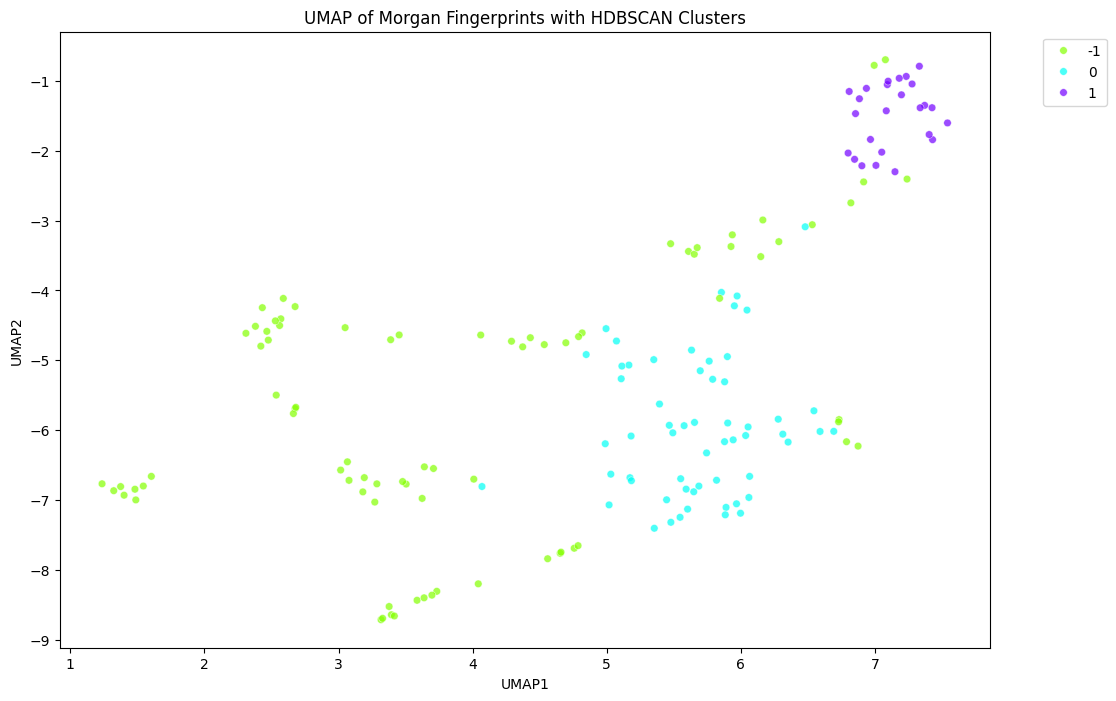

Number of outlier molecules: 82
                                           cleanedMol  \
2               Cn1c(SCc2ccc(Cl)cc2)nnc1-c1cncc(Br)c1   
7                           CCCCCCC#Cc1cncc(C(=O)O)c1   
14  CCCCCCC#Cc1cncc(-c2nnc(SCc3ccc([N+](=O)[O-])cc...   
15  CCCCCCC#Cc1cncc(-c2nnc(SCCCn3ccc(=O)[nH]c3=O)n...   
17  CCCCCCC#Cc1cncc(-c2nnc(SC[C@H]3O[C@@H](n4ccc(=...   

                                             Scaffold  
2                   c1ccc(CSc2nnc(-c3cccnc3)[nH]2)cc1  
7                                            c1ccncc1  
14                  c1ccc(CSc2nnc(-c3cccnc3)[nH]2)cc1  
15       O=c1ccn(CCCSc2nnc(-c3cccnc3)[nH]2)c(=O)[nH]1  
17  O=c1ccn([C@@H]2O[C@H](CSc3nnc(-c4cccnc4)[nH]3)...  
Cluster 0: 58 molecules
Cluster 1: 25 molecules


In [24]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Scaffolds import MurckoScaffold
import umap.umap_ as umap
import hdbscan
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# 0. Check column exists
# -----------------------------
if 'cleanedMol' not in numeric_df.columns:
    raise ValueError("Column 'cleanedMol' not found in numeric_df")

# -----------------------------
# 1. Convert SMILES → Molecule safely
# -----------------------------
def safe_mol_from_smiles(smi):
    if isinstance(smi, str) and smi.strip():  # must be non-empty string
        mol = Chem.MolFromSmiles(smi)
        return mol
    return None

numeric_df['Molecule'] = numeric_df['cleanedMol'].apply(safe_mol_from_smiles)
numeric_df = numeric_df[numeric_df['Molecule'].notna()].reset_index(drop=True)
print(f"Valid molecules: {len(numeric_df)}")

# -----------------------------
# 2. Morgan Fingerprints (2048 bits, radius=2)
# -----------------------------
def calc_fp(mol):
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=1024)
    return np.array(fp, dtype=int)

numeric_df['Fingerprint'] = numeric_df['Molecule'].apply(calc_fp)
fingerprints = np.stack(numeric_df['Fingerprint'].values)

# -----------------------------
# 3. UMAP (2D)
# -----------------------------
umap_model = umap.UMAP(
    n_components=2,
    n_neighbors=30,
    min_dist=0.1,
    metric='jaccard',  # binary fingerprints
    random_state=42
)
umap_result = umap_model.fit_transform(fingerprints)
numeric_df['UMAP1'] = umap_result[:, 0]
numeric_df['UMAP2'] = umap_result[:, 1]

# -----------------------------
# 4. HDBSCAN tuning
# -----------------------------
best_clusters = None
best_score = -1
best_min_size = None
results = []

for min_size in [10, 20, 30, 50, 75, 100]:
    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_size, metric='euclidean')
    labels = clusterer.fit_predict(umap_result)

    # skip if no clusters
    if len(set(labels)) <= 1 or set(labels) == {-1}:
        continue

    mask = labels != -1
    if sum(mask) < 2:
        continue

    score = silhouette_score(umap_result[mask], labels[mask])
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    results.append((min_size, n_clusters, score))

    if score > best_score:
        best_score = score
        best_clusters = labels
        best_min_size = min_size

numeric_df['Cluster'] = best_clusters
print(f"Best HDBSCAN min_cluster_size: {best_min_size}, silhouette: {best_score:.3f}")

# Optional: show all tuning results
results_df = pd.DataFrame(results, columns=['min_size','n_clusters','silhouette_score'])
print(results_df.sort_values('silhouette_score', ascending=False))

# -----------------------------
# 5. Scaffold extraction
# -----------------------------
def get_scaffold_safe(mol):
    try:
        scaffold = MurckoScaffold.GetScaffoldForMol(mol)
        return Chem.MolToSmiles(scaffold)
    except:
        return None

numeric_df['Scaffold'] = numeric_df['Molecule'].apply(get_scaffold_safe)

# -----------------------------
# 6. Visualization
# -----------------------------
plt.figure(figsize=(12, 8))
unique_clusters = sorted(set(best_clusters))
palette = sns.color_palette("hsv", len(unique_clusters))

sns.scatterplot(
    x='UMAP1', y='UMAP2',
    hue='Cluster',
    data=numeric_df,
    palette=palette,
    s=30,
    alpha=0.7,
    legend='full'
)
plt.title("UMAP of Morgan Fingerprints with HDBSCAN Clusters")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.show()

# -----------------------------
# 7. Outliers
# -----------------------------
outliers = numeric_df[numeric_df['Cluster'] == -1]
print(f"Number of outlier molecules: {len(outliers)}")
print(outliers[['cleanedMol', 'Scaffold']].head())

# -----------------------------
# 8. Cluster summary
# -----------------------------
for cluster_id in unique_clusters:
    if cluster_id == -1:
        continue
    cluster_size = sum(best_clusters == cluster_id)
    print(f"Cluster {cluster_id}: {cluster_size} molecules")


In [25]:
numeric_df['transformed_IC50'] = np.log10(numeric_df['IC50 uM'] + 1e-8)

## 🔬 Scaffold-Based Data Splitting (Prevents Leakage!)

**⚠️ CRITICAL CHANGE:** Replacing random K-Fold with scaffold-based splitting

**Why this matters:**
- Random splitting → Similar molecules in train AND test → **Data leakage!**
- Scaffold splitting → Entire scaffolds in train OR test → **No leakage!**

**What we're doing:**
1. Use Bemis-Murcko scaffolds to group molecules
2. Assign entire scaffolds to train/validation/test
3. Verify zero scaffold overlap
4. Analyze train-test similarity
5. Remove near-duplicates (Tanimoto ≥ 0.95)

In [ ]:
# Initialize scaffold splitter
splitter = ScaffoldSplitter(smiles_col='cleanedMol')

# Perform scaffold-based split (70% train, 10% val, 20% test)
train_idx, val_idx, test_idx = splitter.scaffold_split(
    numeric_df,
    test_size=0.2,
    val_size=0.1,
    random_state=42
)

print(f"\n📊 Initial Scaffold Split:")
print(f"   Training: {len(train_idx)} molecules ({len(train_idx)/len(numeric_df)*100:.1f}%)")
print(f"   Validation: {len(val_idx)} molecules ({len(val_idx)/len(numeric_df)*100:.1f}%)")
print(f"   Test: {len(test_idx)} molecules ({len(test_idx)/len(numeric_df)*100:.1f}%)")

In [ ]:
# ✅ Remove near-duplicates between train and test (Tanimoto ≥ 0.95)
print("\n🔍 Checking for near-duplicates between train and test...")
train_idx, test_idx = processor.remove_near_duplicates(
    numeric_df,
    train_idx,
    test_idx,
    threshold=0.95
)

print(f"\n📊 After Near-Duplicate Removal:")
print(f"   Training: {len(train_idx)} molecules")
print(f"   Validation: {len(val_idx)} molecules")
print(f"   Test: {len(test_idx)} molecules")

In [ ]:
# ✅ Analyze train-test similarity (important for reporting!)
print("\n📊 Analyzing Train-Test Similarity...")
similarity_stats = processor.analyze_similarity(numeric_df, train_idx, test_idx)

# Plot similarity distribution
plot_similarity_distribution(similarity_stats, save_path='train_test_similarity.png')

In [ ]:
# ✅ CRITICAL VERIFICATION: Check for SMILES overlap (should be ZERO!)
print("\n" + "="*70)
print("🔍 VERIFICATION: Checking for Data Leakage")
print("="*70)

# Create split dataframes
train_df_clean = numeric_df.iloc[train_idx].reset_index(drop=True)
val_df_clean = numeric_df.iloc[val_idx].reset_index(drop=True)
test_df_clean = numeric_df.iloc[test_idx].reset_index(drop=True)

# Check for SMILES overlap
train_smiles = set(train_df_clean['cleanedMol'])
val_smiles = set(val_df_clean['cleanedMol'])
test_smiles = set(test_df_clean['cleanedMol'])

overlap_train_test = train_smiles & test_smiles
overlap_train_val = train_smiles & val_smiles
overlap_val_test = val_smiles & test_smiles

print(f"\n1. SMILES Overlap Check:")
print(f"   Train-Test overlap: {len(overlap_train_test)} molecules {'✅' if len(overlap_train_test) == 0 else '❌ DATA LEAKAGE!'}")
print(f"   Train-Val overlap: {len(overlap_train_val)} molecules {'✅' if len(overlap_train_val) == 0 else '❌ DATA LEAKAGE!'}")
print(f"   Val-Test overlap: {len(overlap_val_test)} molecules {'✅' if len(overlap_val_test) == 0 else '❌ DATA LEAKAGE!'}")

if overlap_train_test or overlap_train_val or overlap_val_test:
    print("\n⚠️  WARNING: DATA LEAKAGE DETECTED!")
    print("   Some molecules appear in multiple splits. Review splitting code.")
else:
    print("\n✅ PASS: No SMILES overlap detected - splits are clean!")

print("\n2. Dataset Sizes:")
print(f"   Training: {len(train_df_clean)} molecules ({len(train_df_clean)/len(numeric_df)*100:.1f}%)")
print(f"   Validation: {len(val_df_clean)} molecules ({len(val_df_clean)/len(numeric_df)*100:.1f}%)")
print(f"   Test: {len(test_df_clean)} molecules ({len(test_df_clean)/len(numeric_df)*100:.1f}%)")
print(f"   Total: {len(numeric_df)} molecules")

print("\n3. Similarity Analysis:")
print(f"   Mean train-test similarity: {similarity_stats['mean']:.3f}")
print(f"   Median train-test similarity: {similarity_stats['median']:.3f}")
print(f"   Min train-test similarity: {similarity_stats['min']:.3f}")
print(f"   Max train-test similarity: {similarity_stats['max']:.3f}")

print("\n" + "="*70)
if len(overlap_train_test) == 0 and len(overlap_train_val) == 0 and len(overlap_val_test) == 0:
    print("🎉 ALL CHECKS PASSED - Ready for model training!")
else:
    print("⚠️  STOP: Fix data leakage before continuing")
print("="*70)

## 📊 COMPREHENSIVE VALIDATION ANALYSIS

**Critical checks beyond data leakage:**

1. **Dataset Bias & Representativeness**: Scaffold diversity analysis
2. **Model Complexity Control**: Samples-to-features ratio check
3. **Activity Cliffs Detection**: Identify SAR discontinuities
4. **Measurement Noise**: Compare to assay precision
5. **Target Distribution**: Check for range compression
6. **Performance Baselines**: Ridge regression comparison
7. **Y-Randomization Test**: Detect overfitting

📌 **Expected outcome**: Performance will be LOWER than before fixes, but more realistic and honest.

In [ ]:
# 5. COMPREHENSIVE VALIDATION CHECKLIST
print("\n" + "=" * 80)
print("5. VALIDATION CHECKLIST & BEST PRACTICES")
print("=" * 80)

print_comprehensive_validation_checklist()

print("\n" + "=" * 80)
print("✓ VALIDATION ANALYSIS COMPLETE")
print("=" * 80)
print("\n📌 NEXT STEPS:")
print("1. Generate fingerprints PER SPLIT (not before splitting)")
print("2. Fit scaler on TRAINING data only")
print("3. Train model with appropriate regularization")
print("4. Calculate baseline Ridge regression performance")
print("5. Perform y-randomization test")
print("6. Report ALL metrics (RMSE, MAE, R², Spearman)")
print("7. Compare final RMSE to assay error (~0.5 log units)")
print("\n📌 EXPECTED: Performance will be LOWER but MORE REALISTIC")

In [ ]:
# 4. EXPERIMENTAL ERROR ESTIMATION
print("\n" + "=" * 80)
print("4. EXPERIMENTAL ERROR / ASSAY NOISE")
print("=" * 80)

noise_estimator = AssayNoiseEstimator()
error_estimate = noise_estimator.estimate_experimental_error(df, 'IC50 uM')

print(f"\n📌 CRITICAL THRESHOLD:")
print(f"   Expected assay error: ~{error_estimate['experimental_error']:.1f} log units")
print(f"   If model RMSE < {error_estimate['experimental_error']:.1f}, check for:")
print("   • Data leakage")
print("   • Overfitting")
print("   • Lucky train/test split")
print(f"\n   Model RMSE ≈ {error_estimate['experimental_error']:.1f} is EXCELLENT performance")
print("   (near theoretical limit for IC50 assays)")

In [ ]:
# 3. ACTIVITY CLIFF DETECTION
print("\n" + "=" * 80)
print("3. ACTIVITY CLIFF DETECTION")
print("=" * 80)

cliff_detector = ActivityCliffDetector(smiles_col='Canonical SMILES', target_col='IC50 uM')

# Detect activity cliffs (this may take a minute for larger datasets)
cliff_df = cliff_detector.detect_activity_cliffs(
    df2,  # Use training set only
    similarity_threshold=0.85,  # High structural similarity
    activity_threshold=2.0       # 100-fold difference (2 log units)
)

if len(cliff_df) > 0:
    print(f"\n⚠️ Found {len(cliff_df)} activity cliff pairs in training set")
    print("   → Feature importance interpretation should be cautious")
    print("   → Local predictivity may be limited")
    print("   → Consider Gaussian Process for better handling")
else:
    print("\n✓ No major activity cliffs detected")
    print("  → SAR appears continuous")
    print("  → Fingerprint-based models should work well")

In [ ]:
# 2. MODEL COMPLEXITY ANALYSIS
print("\n" + "=" * 80)
print("2. MODEL COMPLEXITY ANALYSIS")
print("=" * 80)

# Note: Fingerprints will be generated later, but we know dimensions
n_samples = len(df2)  # Training set size
n_features = 1024     # Circular fingerprint size

ModelComplexityAnalyzer.analyze_complexity(
    n_samples=n_samples,
    n_features=n_features,
    model_type='random_forest'  # H2O AutoML often selects RF/GBM
)

print(f"\n📌 KEY INSIGHT:")
print(f"   Samples:Features ratio = {n_samples}:{n_features} = {n_samples/n_features:.2f}:1")
if n_samples / n_features < 5:
    print("   ⚠️ CRITICAL: Very low ratio - strong regularization REQUIRED")
elif n_samples / n_features < 10:
    print("   🟠 WARNING: Low ratio - use regularized models")
else:
    print("   ✓ Adequate ratio for complex models")

In [ ]:
# 1. DATASET BIAS & REPRESENTATIVENESS ANALYSIS
print("=" * 80)
print("1. DATASET BIAS & REPRESENTATIVENESS ANALYSIS")
print("=" * 80)

analyzer = DatasetBiasAnalyzer(smiles_col='Canonical SMILES', target_col='IC50 uM')

# Scaffold diversity analysis
diversity_results = analyzer.analyze_scaffold_diversity(df)

# Activity distribution analysis
activity_stats = analyzer.analyze_activity_distribution(df)

# Report scaffold diversity per split
analyzer.report_split_diversity(
    diversity_results['df_with_scaffolds'],
    train_idx,
    val_idx,
    test_idx
)

In [ ]:
# Import validation utilities
from qsar_validation_utils import (
    DatasetBiasAnalyzer,
    ActivityCliffDetector,
    ModelComplexityAnalyzer,
    PerformanceMetricsCalculator,
    YRandomizationTester,
    AssayNoiseEstimator,
    print_comprehensive_validation_checklist
)

print("✓ Validation utilities loaded")

In [ ]:
# ✅ Prepare splits for feature generation and model training
# For backward compatibility, we'll update df2 to be the training set
# This allows the rest of the notebook to work with minimal changes

print("\n📦 Preparing data for model training...")

# Save original numeric_df
numeric_df_original = numeric_df.copy()

# Update df2 to be the TRAINING set only (this is what H2O will use)
df2 = train_df_clean.copy()

# Save validation and test sets separately
df_validation = val_df_clean.copy()
df_test = test_df_clean.copy()

print(f"\n✅ Data prepared:")
print(f"   df2 (training): {len(df2)} molecules")
print(f"   df_validation: {len(df_validation)} molecules")
print(f"   df_test: {len(df_test)} molecules")

print("\n⚠️  IMPORTANT NOTES:")
print("   1. Feature generation should be done AFTER this split")
print("   2. Any scalers should be fitted on df2 (training) ONLY")
print("   3. Then transform df_validation and df_test using the same scaler")
print("   4. DO NOT use the entire numeric_df for feature scaling!")

# Store indices for reference
train_indices = train_idx
val_indices = val_idx
test_indices = test_idx

## Baseline-Model

### Rdkit

In [26]:
df=numeric_df

In [27]:
# Importing pandas as pd
import pandas as pd

# Import RDKit modules
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np

# Function to calculate circular (Morgan) fingerprint
def calculate_circular_fingerprint(smiles, radius=2, nBits=1024):
    # Convert SMILES to RDKit molecule
    mol = Chem.MolFromSmiles(smiles)

    if mol is None:
        # Return NaNs if molecule is invalid
        return np.full(nBits, np.nan)

    # Calculate Morgan fingerprint as a bit vector
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=nBits)

    # Convert to numpy array
    arr = np.zeros((nBits,), dtype=int)
    AllChem.DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

# Apply to your DataFrame
fingerprint_array = np.array(df['cleanedMol'].apply(lambda x: calculate_circular_fingerprint(x, radius=2, nBits=1024)).tolist())

# Convert array to DataFrame
fp_df = pd.DataFrame(fingerprint_array, columns=[f'FP_{i}' for i in range(fingerprint_array.shape[1])])

# Merge with original DataFrame
df = pd.concat([df.reset_index(drop=True), fp_df.reset_index(drop=True)], axis=1)


[18:26:26] DEPRECATION WARNING: please use MorganGenerator
[18:26:26] DEPRECATION WARNING: please use MorganGenerator
[18:26:26] DEPRECATION WARNING: please use MorganGenerator
[18:26:26] DEPRECATION WARNING: please use MorganGenerator
[18:26:26] DEPRECATION WARNING: please use MorganGenerator
[18:26:26] DEPRECATION WARNING: please use MorganGenerator
[18:26:26] DEPRECATION WARNING: please use MorganGenerator
[18:26:26] DEPRECATION WARNING: please use MorganGenerator
[18:26:26] DEPRECATION WARNING: please use MorganGenerator
[18:26:26] DEPRECATION WARNING: please use MorganGenerator
[18:26:26] DEPRECATION WARNING: please use MorganGenerator
[18:26:26] DEPRECATION WARNING: please use MorganGenerator
[18:26:26] DEPRECATION WARNING: please use MorganGenerator
[18:26:26] DEPRECATION WARNING: please use MorganGenerator
[18:26:26] DEPRECATION WARNING: please use MorganGenerator
[18:26:26] DEPRECATION WARNING: please use MorganGenerator
[18:26:26] DEPRECATION WARNING: please use MorganGenerat

In [28]:
df

,Identifier,Canonical SMILES,IC50 uM,PIC50,valid_smiles,cleanedMol,Molecule,Fingerprint,UMAP1,UMAP2,...,FP_1014,FP_1015,FP_1016,FP_1017,FP_1018,FP_1019,FP_1020,FP_1021,FP_1022,FP_1023
0,TB-VS0012,CCCCCCC#CC1=CC(C2=NN=C(SCC3=CC=C(Cl)C=C3)N2C)=...,5.300,5.275724,True,CCCCCCC#Cc1cncc(-c2nnc(SCc3ccc(Cl)cc3)n2C)c1,<rdkit.Chem.rdchem.Mol object at 0x78aafbab22d0>,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",5.901679,-5.896371,...,0,0,0,0,0,0,0,0,0,0
1,TB-VS12-2,BrC1=CC(C2=NN=C(N2C)S)=CN=C1,200.000,3.698970,True,Cn1c(-c2cncc(Br)c2)n[nH]c1=S,<rdkit.Chem.rdchem.Mol object at 0x78aafb79cb30>,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5.172891,-6.678698,...,0,0,0,0,0,0,0,0,0,0
2,TB-VS12-3,BrC1=CC(C2=NN=C(N2C)SCC3=CC=C(C=C3)Cl)=CN=C1,200.000,3.698970,True,Cn1c(SCc2ccc(Cl)cc2)nnc1-c1cncc(Br)c1,<rdkit.Chem.rdchem.Mol object at 0x78aafb79cba0>,"[0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",6.731848,-5.847458,...,0,0,0,0,0,0,0,0,0,0
3,TB-VS12-4,CCCCCCC#CC1=CC(C2=NN=C(N2C)S)=CN=C1,22.570,4.646468,True,CCCCCCC#Cc1cncc(-c2n[nH]c(=S)n2C)c1,<rdkit.Chem.rdchem.Mol object at 0x78aafb79d9a0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5.030171,-6.628533,...,0,0,0,0,0,0,0,0,0,0
4,TB-VS12-5,CCCCCCC#CC1=CC(C2=NN=C(SCC3=CC=CC=C3)N2C)=CN=C1,175.000,3.756962,True,CCCCCCC#Cc1cncc(-c2nnc(SCc3ccccc3)n2C)c1,<rdkit.Chem.rdchem.Mol object at 0x78aafb79e180>,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",5.446123,-6.995073,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,ROY-0000175-001,CC(OC(N(C1)CC21CCN(C3=CC(C#CC4=CC=CC=C4)=CN=C3...,6.843,5.164753,True,CC(C)(C)OC(=O)N1CC2(CCN(c3cncc(C#Cc4ccccc4)c3)...,<rdkit.Chem.rdchem.Mol object at 0x78aafb89e6c0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",5.936086,-3.203421,...,0,0,0,0,0,0,0,0,0,0
161,ROY-0000223-001,ClC(C=C1)=CC=C1CO[C@H](CC2)CN2C3=CC(C#CC4=CC=C...,5.615,5.250650,True,FC(F)(F)Oc1ccc(C#Cc2cncc(N3CC[C@@H](OCc4ccc(Cl...,<rdkit.Chem.rdchem.Mol object at 0x78aafb89e730>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5.951382,-4.219354,...,0,0,0,0,1,1,0,0,0,0
162,ROY-0000222-001,ClC(C=C1)=CC=C1CO[C@H](CC2)CN2C3=CC(C#CC4=CC=C...,9.705,5.013004,True,Clc1ccc(CO[C@@H]2CCN(c3cncc(C#Cc4ccccc4)c3)C2)cc1,<rdkit.Chem.rdchem.Mol object at 0x78aafb89e7a0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6.045620,-4.280353,...,0,0,0,0,1,1,0,0,0,0
163,ROY-0000225-001,CC(OC(N1CC(OCCCC2=CC=CC=C2)C1)=O)(C)C,148.000,3.829738,True,CC(C)(C)OC(=O)N1CC(OCCCc2ccccc2)C1,<rdkit.Chem.rdchem.Mol object at 0x78aafb89e810>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, ...",6.163700,-2.991008,...,0,0,0,0,0,1,0,0,0,0


In [29]:
feature1=df.iloc[:, 16:]

In [30]:
df

,Identifier,Canonical SMILES,IC50 uM,PIC50,valid_smiles,cleanedMol,Molecule,Fingerprint,UMAP1,UMAP2,...,FP_1014,FP_1015,FP_1016,FP_1017,FP_1018,FP_1019,FP_1020,FP_1021,FP_1022,FP_1023
0,TB-VS0012,CCCCCCC#CC1=CC(C2=NN=C(SCC3=CC=C(Cl)C=C3)N2C)=...,5.300,5.275724,True,CCCCCCC#Cc1cncc(-c2nnc(SCc3ccc(Cl)cc3)n2C)c1,<rdkit.Chem.rdchem.Mol object at 0x78aafbab22d0>,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",5.901679,-5.896371,...,0,0,0,0,0,0,0,0,0,0
1,TB-VS12-2,BrC1=CC(C2=NN=C(N2C)S)=CN=C1,200.000,3.698970,True,Cn1c(-c2cncc(Br)c2)n[nH]c1=S,<rdkit.Chem.rdchem.Mol object at 0x78aafb79cb30>,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5.172891,-6.678698,...,0,0,0,0,0,0,0,0,0,0
2,TB-VS12-3,BrC1=CC(C2=NN=C(N2C)SCC3=CC=C(C=C3)Cl)=CN=C1,200.000,3.698970,True,Cn1c(SCc2ccc(Cl)cc2)nnc1-c1cncc(Br)c1,<rdkit.Chem.rdchem.Mol object at 0x78aafb79cba0>,"[0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",6.731848,-5.847458,...,0,0,0,0,0,0,0,0,0,0
3,TB-VS12-4,CCCCCCC#CC1=CC(C2=NN=C(N2C)S)=CN=C1,22.570,4.646468,True,CCCCCCC#Cc1cncc(-c2n[nH]c(=S)n2C)c1,<rdkit.Chem.rdchem.Mol object at 0x78aafb79d9a0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5.030171,-6.628533,...,0,0,0,0,0,0,0,0,0,0
4,TB-VS12-5,CCCCCCC#CC1=CC(C2=NN=C(SCC3=CC=CC=C3)N2C)=CN=C1,175.000,3.756962,True,CCCCCCC#Cc1cncc(-c2nnc(SCc3ccccc3)n2C)c1,<rdkit.Chem.rdchem.Mol object at 0x78aafb79e180>,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",5.446123,-6.995073,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,ROY-0000175-001,CC(OC(N(C1)CC21CCN(C3=CC(C#CC4=CC=CC=C4)=CN=C3...,6.843,5.164753,True,CC(C)(C)OC(=O)N1CC2(CCN(c3cncc(C#Cc4ccccc4)c3)...,<rdkit.Chem.rdchem.Mol object at 0x78aafb89e6c0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",5.936086,-3.203421,...,0,0,0,0,0,0,0,0,0,0
161,ROY-0000223-001,ClC(C=C1)=CC=C1CO[C@H](CC2)CN2C3=CC(C#CC4=CC=C...,5.615,5.250650,True,FC(F)(F)Oc1ccc(C#Cc2cncc(N3CC[C@@H](OCc4ccc(Cl...,<rdkit.Chem.rdchem.Mol object at 0x78aafb89e730>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5.951382,-4.219354,...,0,0,0,0,1,1,0,0,0,0
162,ROY-0000222-001,ClC(C=C1)=CC=C1CO[C@H](CC2)CN2C3=CC(C#CC4=CC=C...,9.705,5.013004,True,Clc1ccc(CO[C@@H]2CCN(c3cncc(C#Cc4ccccc4)c3)C2)cc1,<rdkit.Chem.rdchem.Mol object at 0x78aafb89e7a0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6.045620,-4.280353,...,0,0,0,0,1,1,0,0,0,0
163,ROY-0000225-001,CC(OC(N1CC(OCCCC2=CC=CC=C2)C1)=O)(C)C,148.000,3.829738,True,CC(C)(C)OC(=O)N1CC(OCCCc2ccccc2)C1,<rdkit.Chem.rdchem.Mol object at 0x78aafb89e810>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, ...",6.163700,-2.991008,...,0,0,0,0,0,1,0,0,0,0


In [31]:
target=df['transformed_IC50']
target.head()

,transformed_IC50
0,0.724276
1,2.301030
2,2.301030
3,1.353532
4,2.243038


In [32]:
# Install H2O if not already installed
!pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o

Looking in links: http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.0/266.0 MB 6.4 MB/s eta 0:00:00


Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.28" 2025-07-15; OpenJDK Runtime Environment (build 11.0.28+6-post-Ubuntu-1ubuntu122.04.1); OpenJDK 64-Bit Server VM (build 11.0.28+6-post-Ubuntu-1ubuntu122.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.12/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp9cge95d5
  JVM stdout: /tmp/tmp9cge95d5/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp9cge95d5/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,06 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.9
H2O_cluster_version_age:,11 days
H2O_cluster_name:,H2O_from_python_unknownUser_8ctm21
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,4 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Training fold 1/5...
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
18:27:25.584: Project: AutoML_1_20251205_182725
18:27:25.595: 5-fold cross-validation will be used.
18:27:25.604: Setting stopping tolerance adaptively based on the training frame: 0.05
18:27:25.605: Build control seed: 42
18:27:25.628: training frame: Frame key: AutoML_1_20251205_182725_training_Key_Frame__upload_ad61e0ec7424a899af6734e9fb0740fc.hex    cols: 1022    rows: 132  chunks: 1    size: 84538  checksum: -6952059905916605964
18:27:25.628: validation frame: NULL
18:27:25.628: leaderboard frame: NULL
18:27:25.629: blending frame: NULL
18:27:25.629: response column: transformed_IC50
18:27:25.629: fold column: null
18:27:25.629: weights column: null
18:27:25.806: Loading execution steps: [{XGBoost : [def_2 (1g, 10w), def_1 (2g, 10w), def_3 (3g, 10w), grid

/usr/local/lib/python3.12/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
18:28:52.666: Project: AutoML_2_20251205_182852
18:28:52.668: 5-fold cross-validation will be used.
18:28:52.670: Setting stopping tolerance adaptively based on the training frame: 0.05
18:28:52.670: Build control seed: 42
18:28:52.673: training frame: Frame key: AutoML_2_20251205_182852_training_Key_Frame__upload_ae2e832a057ae7ae1decae7dc8046c0.hex    cols: 1022    rows: 132  chunks: 1    size: 84714  checksum: 4445716636741258940
18:28:52.673: validation frame: NULL
18:28:52.673: leaderboard frame: NULL
18:28:52.673: blending frame: NULL
18:28:52.673: response column: transformed_IC50
18:28:52.674: fold column: null
18:28:52.674: weights column: null
18:28:52.674: Loading execution steps: [{XGBoost : [def_2 (1g, 10w), def_1 (2g, 10w), def_3 (3g, 10w), grid_1 (4g, 90w), lr_search (7g, 30w)]}, {GLM : [def_1 (1g, 10w)]}, {DRF : [def_1 (2g, 10w), XRT (3g, 10w)]}, {GBM : [def_

/usr/local/lib/python3.12/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
18:29:38.600: Project: AutoML_3_20251205_182938
18:29:38.601: 5-fold cross-validation will be used.
18:29:38.602: Setting stopping tolerance adaptively based on the training frame: 0.05
18:29:38.602: Build control seed: 42
18:29:38.603: training frame: Frame key: AutoML_3_20251205_182938_training_Key_Frame__upload_9601572101837f6865d2f320982f405d.hex    cols: 1022    rows: 132  chunks: 1    size: 84645  checksum: 5755629340707453020
18:29:38.603: validation frame: NULL
18:29:38.603: leaderboard frame: NULL
18:29:38.603: blending frame: NULL
18:29:38.603: response column: transformed_IC50
18:29:38.603: fold column: null
18:29:38.603: weights column: null
18:29:38.604: Loading execution steps: [{XGBoost : [def_2 (1g, 10w), def_1 (2g, 10w), def_3 (3g, 10w), grid_1 (4g, 90w), lr_search (7g, 30w)]}, {GLM : [def_1 (1g, 10w)]}, {DRF : [def_1 (2g, 10w), XRT (3g, 10w)]}, {GBM : [def

/usr/local/lib/python3.12/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
18:30:18.208: Project: AutoML_4_20251205_183018
18:30:18.210: 5-fold cross-validation will be used.
18:30:18.214: Setting stopping tolerance adaptively based on the training frame: 0.05
18:30:18.214: Build control seed: 42
18:30:18.217: training frame: Frame key: AutoML_4_20251205_183018_training_Key_Frame__upload_901ed23a263b5e5724542fd1f5fd4a07.hex    cols: 1022    rows: 132  chunks: 1    size: 84598  checksum: 7137521763639092116
18:30:18.217: validation frame: NULL
18:30:18.217: leaderboard frame: NULL
18:30:18.217: blending frame: NULL
18:30:18.217: response column: transformed_IC50
18:30:18.217: fold column: null
18:30:18.217: weights column: null
18:30:18.218: Loading execution steps: [{XGBoost : [def_2 (1g, 10w), def_1 (2g, 10w), def_3 (3g, 10w), grid_1 (4g, 90w), lr_search (7g, 30w)]}, {GLM : [def_1 (1g, 10w)]}, {DRF : [def_1 (2g, 10w), XRT (3g, 10w)]}, {GBM : [def

/usr/local/lib/python3.12/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
18:30:56.625: Project: AutoML_5_20251205_183056
18:30:56.625: 5-fold cross-validation will be used.
18:30:56.630: Setting stopping tolerance adaptively based on the training frame: 0.05
18:30:56.630: Build control seed: 42
18:30:56.634: training frame: Frame key: AutoML_5_20251205_183056_training_Key_Frame__upload_9dafd9359da95b24257d68d7f4df4252.hex    cols: 1022    rows: 132  chunks: 1    size: 84460  checksum: 5789966852534273436
18:30:56.634: validation frame: NULL
18:30:56.634: leaderboard frame: NULL
18:30:56.634: blending frame: NULL
18:30:56.634: response column: transformed_IC50
18:30:56.634: fold column: null
18:30:56.634: weights column: null
18:30:56.635: Loading execution steps: [{XGBoost : [def_2 (1g, 10w), def_1 (2g, 10w), def_3 (3g, 10w), grid_1 (4g, 90w), lr_search (7g, 30w)]}, {GLM : [def_1 (1g, 10w)]}, {DRF : [def_1 (2g, 10w), XRT (3g, 10w)]}, {GBM : [def_5 (1g, 10w), def

/usr/local/lib/python3.12/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


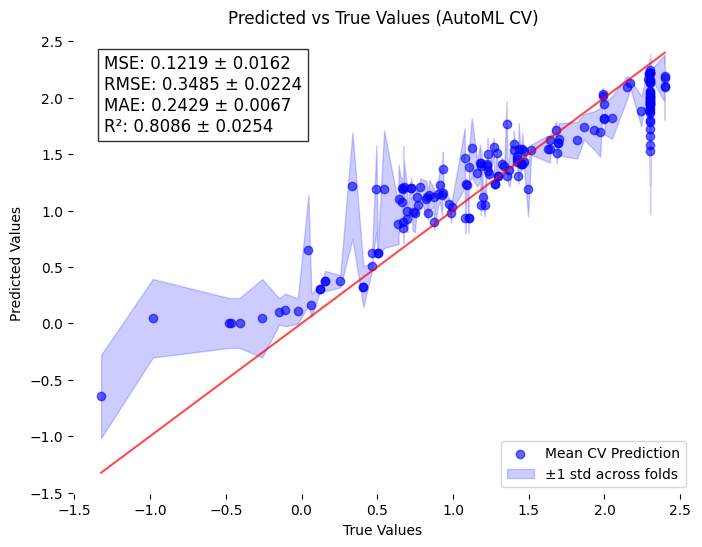

AutoML progress: |
18:31:34.212: Project: AutoML_6_20251205_183134
18:31:34.213: 5-fold cross-validation will be used.
18:31:34.214: Setting stopping tolerance adaptively based on the training frame: 0.05
18:31:34.214: Build control seed: 42
18:31:34.215: training frame: Frame key: AutoML_6_20251205_183134_training_Key_Frame__upload_ac2f71404a9104e814a98340ae34f49.hex    cols: 1022    rows: 165  chunks: 1    size: 85762  checksum: -8899254813974570500
18:31:34.215: validation frame: NULL
18:31:34.215: leaderboard frame: NULL
18:31:34.215: blending frame: NULL
18:31:34.215: response column: transformed_IC50
18:31:34.215: fold column: null
18:31:34.215: weights column: null
18:31:34.216: Loading execution steps: [{XGBoost : [def_2 (1g, 10w), def_1 (2g, 10w), def_3 (3g, 10w), grid_1 (4g, 90w), lr_search (7g, 30w)]}, {GLM : [def_1 (1g, 10w)]}, {DRF : [def_1 (2g, 10w), XRT (3g, 10w)]}, {GBM : [def_5 (1g, 10w), def_2 (2g, 10w), def_3 (2g, 10w), def_4 (2g, 10w), def_1 (3g, 10w), grid_1 (4g, 6

In [33]:
import h2o
from h2o.automl import H2OAutoML
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# -----------------------------
# 1️⃣ Prepare Data
# -----------------------------
X = feature1  # Your features DataFrame
y = target    # Your target Series
df2 = pd.concat([X, y], axis=1)

# Initialize H2O
h2o.init(max_mem_size="4G")
hf_full = h2o.H2OFrame(df2)

x_cols = X.columns.tolist()
y_col = y.name

# -----------------------------
# 2️⃣ Manual K-Fold CV with AutoML
# -----------------------------
K = 5
kf = KFold(n_splits=K, shuffle=True, random_state=42)

cv_preds_all = []
y_true = df2[y_col].values

for fold, (train_idx, valid_idx) in enumerate(kf.split(df2), 1):
    print(f"Training fold {fold}/{K}...")

    train_hf = h2o.H2OFrame(df2.iloc[train_idx])

    aml = H2OAutoML(
        max_models=10,
        seed=42,
        exclude_algos=[],
        verbosity="info"
    )
    aml.train(x=x_cols, y=y_col, training_frame=train_hf)

    # Predict on full dataset for per-fold predictions
    preds = aml.leader.predict(hf_full).as_data_frame().values.flatten()
    cv_preds_all.append(preds)

cv_preds_all = np.array(cv_preds_all).T  # shape: (n_samples, n_folds)

# -----------------------------
# 3️⃣ Compute mean and std across folds
# -----------------------------
y_pred_mean = cv_preds_all.mean(axis=1)
y_pred_std = cv_preds_all.std(axis=1)

# -----------------------------
# 4️⃣ Compute metrics (mean ± std across folds)
# -----------------------------
fold_metrics = []
for fold_preds in cv_preds_all.T:
    fold_mse = mean_squared_error(y_true, fold_preds)
    fold_rmse = np.sqrt(fold_mse)
    fold_mae = mean_absolute_error(y_true, fold_preds)
    fold_r2 = r2_score(y_true, fold_preds)
    fold_metrics.append([fold_mse, fold_rmse, fold_mae, fold_r2])

fold_metrics = np.array(fold_metrics)
mse_mean, rmse_mean, mae_mean, r2_mean = fold_metrics.mean(axis=0)
mse_std, rmse_std, mae_std, r2_std = fold_metrics.std(axis=0)

metrics_text = (
    f"MSE: {mse_mean:.4f} ± {mse_std:.4f}\n"
    f"RMSE: {rmse_mean:.4f} ± {rmse_std:.4f}\n"
    f"MAE: {mae_mean:.4f} ± {mae_std:.4f}\n"
    f"R²: {r2_mean:.4f} ± {r2_std:.4f}"
)

print("Cross-validation metrics (mean ± std across folds):")
print(metrics_text)

# -----------------------------
# 5️⃣ Smooth Scatter Plot with Shaded Variance
# -----------------------------
sorted_idx = np.argsort(y_true)
y_true_sorted = y_true[sorted_idx]
y_pred_mean_sorted = y_pred_mean[sorted_idx]
y_pred_std_sorted = y_pred_std[sorted_idx]

plt.figure(figsize=(8, 6))
plt.scatter(y_true_sorted, y_pred_mean_sorted, color='blue', alpha=0.6, label='Mean CV Prediction')
plt.fill_between(
    y_true_sorted,
    y_pred_mean_sorted - y_pred_std_sorted,
    y_pred_mean_sorted + y_pred_std_sorted,
    color='blue', alpha=0.2, label='±1 std across folds'
)
plt.plot(y_true_sorted, y_true_sorted, color='red', alpha=0.7)
plt.title("Predicted vs True Values (AutoML CV)")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.text(
    0.05, 0.95, metrics_text, transform=plt.gca().transAxes,
    fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.8)
)
plt.legend()
plt.grid(False)
plt.box(False)
plt.savefig("predicted_vs_true_values_automl_cv_smooth.png", bbox_inches='tight')
plt.show()

# -----------------------------
# 6️⃣ Train overall leader model on full dataset
# -----------------------------
final_aml = H2OAutoML(
    max_models=10,
    seed=42,
    exclude_algos=[],
    verbosity="info"
)
final_aml.train(x=x_cols, y=y_col, training_frame=hf_full)

overall_leader_model = final_aml.leader
overall_train_set = df2.copy()  # Pandas DataFrame

print("Overall leader model trained on full dataset.")
print(f"Training set shape: {overall_train_set.shape}")


In [34]:
print("Feature columns (used for training):")
print(x_cols)

print("\nTarget column:")
print(y_col)


Feature columns (used for training):
['FP_3', 'FP_4', 'FP_5', 'FP_6', 'FP_7', 'FP_8', 'FP_9', 'FP_10', 'FP_11', 'FP_12', 'FP_13', 'FP_14', 'FP_15', 'FP_16', 'FP_17', 'FP_18', 'FP_19', 'FP_20', 'FP_21', 'FP_22', 'FP_23', 'FP_24', 'FP_25', 'FP_26', 'FP_27', 'FP_28', 'FP_29', 'FP_30', 'FP_31', 'FP_32', 'FP_33', 'FP_34', 'FP_35', 'FP_36', 'FP_37', 'FP_38', 'FP_39', 'FP_40', 'FP_41', 'FP_42', 'FP_43', 'FP_44', 'FP_45', 'FP_46', 'FP_47', 'FP_48', 'FP_49', 'FP_50', 'FP_51', 'FP_52', 'FP_53', 'FP_54', 'FP_55', 'FP_56', 'FP_57', 'FP_58', 'FP_59', 'FP_60', 'FP_61', 'FP_62', 'FP_63', 'FP_64', 'FP_65', 'FP_66', 'FP_67', 'FP_68', 'FP_69', 'FP_70', 'FP_71', 'FP_72', 'FP_73', 'FP_74', 'FP_75', 'FP_76', 'FP_77', 'FP_78', 'FP_79', 'FP_80', 'FP_81', 'FP_82', 'FP_83', 'FP_84', 'FP_85', 'FP_86', 'FP_87', 'FP_88', 'FP_89', 'FP_90', 'FP_91', 'FP_92', 'FP_93', 'FP_94', 'FP_95', 'FP_96', 'FP_97', 'FP_98', 'FP_99', 'FP_100', 'FP_101', 'FP_102', 'FP_103', 'FP_104', 'FP_105', 'FP_106', 'FP_107', 'FP_108', 'FP_10

In [35]:
# Save the model to a folder
model_path = h2o.save_model(model=overall_leader_model, path="./saved_models", force=True)
print(f"Model saved to: {model_path}")


Model saved to: /content/saved_models/StackedEnsemble_AllModels_1_AutoML_6_20251205_183134


In [38]:
# -----------------------------
# Complete H2O prediction pipeline for new SMILES with inverse log10
# -----------------------------
import pandas as pd
import h2o
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np
numeric_df['cleanedMol']=numeric_df['Canonical SMILES'].apply(standardize_smiles, verbose=True)
numeric_df
# -----------------------------
# 1️⃣ Example SMILES
# -----------------------------
smiles_list = [
    'CCCCCCC#CC1=CN=CC(N2CCC3(CN(C(C4=CC([N+]([O-])=O)=CC([N+]([O-])=O)=C4)=O)C3)C2)=C1',  # Cyclohexanol, likely weak
      # Pyridine, likely weak
]

# -----------------------------
# 2️⃣ Function to calculate circular (Morgan) fingerprints
# -----------------------------
def calculate_circular_fingerprint(smiles, radius=2, nBits=1024):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return np.full(nBits, np.nan)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=nBits)
    arr = np.zeros((nBits,), dtype=int)
    AllChem.DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

# -----------------------------
# 3️⃣ Convert SMILES to fingerprint DataFrame
# -----------------------------
fingerprint_array = np.array([calculate_circular_fingerprint(smi, radius=2, nBits=1024) for smi in smiles_list])
new_data = pd.DataFrame(fingerprint_array, columns=[f'FP_{i}' for i in range(fingerprint_array.shape[1])])

# -----------------------------
# 4️⃣ Ensure columns match training features
# -----------------------------
# x_cols should be the feature columns used in training
# Example: x_cols = ['FP_0', 'FP_1', ..., 'FP_1023']
new_data = new_data[x_cols]  # reorder columns to match training

# -----------------------------
# 5️⃣ Initialize H2O
# -----------------------------
h2o.init(max_mem_size="4G")

# -----------------------------
# 6️⃣ Load the saved model
# -----------------------------
model_path = "/content/saved_models/StackedEnsemble_AllModels_1_AutoML_6_20251205_183134"
loaded_model = h2o.load_model(model_path)
print("Model loaded successfully.")

# -----------------------------
# 7️⃣ Convert new data to H2OFrame and predict
# -----------------------------
new_data_hf = h2o.H2OFrame(new_data)
preds = loaded_model.predict(new_data_hf).as_data_frame()

# -----------------------------
# 8️⃣ Convert predictions from log10 back to original scale
# -----------------------------
preds_original = 10 ** preds['predict']

# Combine SMILES with predicted values
preds_final = pd.DataFrame({
    'SMILES': smiles_list,
    'Predicted_original_scale': preds_original
})

print("Predictions on original scale:")
print(preds_final)


Original: CCCCCCC#CC1=CC(C2=NN=C(SCC3=CC=C(Cl)C=C3)N2C)=CN=C1
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SCc3ccc(Cl)cc3)n2C)c1
Original: BrC1=CC(C2=NN=C(N2C)S)=CN=C1
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
Cn1c(-c2cncc(Br)c2)n[nH]c1=S
Original: BrC1=CC(C2=NN=C(N2C)SCC3=CC=C(C=C3)Cl)=CN=C1
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
Cn1c(SCc2ccc(Cl)cc2)nnc1-c1cncc(Br)c1
Original: CCCCCCC#CC1=CC(C2=NN=C(N2C)S)=CN=C1
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2n[nH]c(=S)n2C)c1
Original: CCCCCCC#

[18:34:34] Initializing MetalDisconnector
[18:34:34] Running MetalDisconnector
[18:34:34] Initializing Normalizer
[18:34:34] Running Normalizer
[18:34:34] Initializing MetalDisconnector
[18:34:34] Running MetalDisconnector
[18:34:34] Initializing Normalizer
[18:34:34] Running Normalizer
[18:34:34] Running LargestFragmentChooser
[18:34:34] Running Uncharger
[18:34:34] Initializing MetalDisconnector
[18:34:34] Running MetalDisconnector
[18:34:34] Initializing Normalizer
[18:34:34] Running Normalizer
[18:34:34] Initializing MetalDisconnector
[18:34:34] Running MetalDisconnector
[18:34:34] Initializing Normalizer
[18:34:34] Running Normalizer
[18:34:34] Running LargestFragmentChooser
[18:34:34] Running Uncharger
[18:34:34] Initializing MetalDisconnector
[18:34:34] Running MetalDisconnector
[18:34:34] Initializing Normalizer
[18:34:34] Running Normalizer
[18:34:34] Initializing MetalDisconnector
[18:34:34] Running MetalDisconnector
[18:34:34] Initializing Normalizer
[18:34:34] Running Norma

Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SCc3ccc(F)cc3)n2C)c1
Original: O=C(O)C1=CC(C#CCCCCCC)=CN=C1
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(C(=O)O)c1
Original: CCCCCCC#CC1=CC(C2=NN=C(SCC3=CC(Cl)=C(Cl)C=C3)N2C)=CN=C1
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SCc3ccc(Cl)c(Cl)c3)n2C)c1
Original: CCCCCCC#CC1=CC(C2=NN=C(SCC3=CC=C(C4=CC=CC=C4)C=C3)N2C)=CN=C1
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SCc3ccc(-c4ccccc4)cc3)n2C)c1
Original: CCCCCCC#CC1

[18:34:34] Running Normalizer
[18:34:34] Initializing MetalDisconnector
[18:34:34] Running MetalDisconnector
[18:34:34] Initializing Normalizer
[18:34:34] Running Normalizer
[18:34:34] Running LargestFragmentChooser
[18:34:34] Running Uncharger
[18:34:34] Initializing MetalDisconnector
[18:34:34] Running MetalDisconnector
[18:34:34] Initializing Normalizer
[18:34:34] Running Normalizer
[18:34:34] Initializing MetalDisconnector
[18:34:34] Running MetalDisconnector
[18:34:34] Initializing Normalizer
[18:34:34] Running Normalizer
[18:34:34] Running LargestFragmentChooser
[18:34:34] Running Uncharger
[18:34:34] Initializing MetalDisconnector
[18:34:34] Running MetalDisconnector
[18:34:34] Initializing Normalizer
[18:34:34] Running Normalizer
[18:34:34] Initializing MetalDisconnector
[18:34:34] Running MetalDisconnector
[18:34:34] Initializing Normalizer
[18:34:34] Running Normalizer
[18:34:34] Running LargestFragmentChooser
[18:34:34] Running Uncharger
[18:34:34] Initializing MetalDisconne

Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
[C-]#[N+]c1ccc(CSc2nnc(-c3cncc(C#CCCCCCC)c3)n2C)cc1
Original: CCCCCCC#CC1=CC(C2=NN=C(SCC3=CC=C(C)C=C3)N2C)=CN=C1
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SCc3ccc(C)cc3)n2C)c1
Original: CCCCCCC#CC1=CC(C2=NN=C(SCC3=CC=C(OC)C=C3)N2C)=CN=C1
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SCc3ccc(OC)cc3)n2C)c1
Original: CCCCCCC#CC1=CC(C2=NN=C(SCC3=CC=C([N+]([O-])=O)C=C3)N2C)=CN=C1
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SCc3ccc([

[18:34:34] Running LargestFragmentChooser
[18:34:34] Running Uncharger
[18:34:34] Initializing MetalDisconnector
[18:34:34] Running MetalDisconnector
[18:34:34] Initializing Normalizer
[18:34:34] Running Normalizer
[18:34:34] Initializing MetalDisconnector
[18:34:34] Running MetalDisconnector
[18:34:34] Initializing Normalizer
[18:34:34] Running Normalizer
[18:34:34] Running LargestFragmentChooser
[18:34:34] Running Uncharger
[18:34:34] Initializing MetalDisconnector
[18:34:34] Running MetalDisconnector
[18:34:34] Initializing Normalizer
[18:34:34] Running Normalizer
[18:34:34] Initializing MetalDisconnector
[18:34:34] Running MetalDisconnector
[18:34:34] Initializing Normalizer
[18:34:34] Running Normalizer
[18:34:34] Running LargestFragmentChooser
[18:34:34] Running Uncharger
[18:34:34] Initializing MetalDisconnector
[18:34:34] Running MetalDisconnector
[18:34:34] Initializing Normalizer
[18:34:34] Running Normalizer
[18:34:34] Initializing MetalDisconnector
[18:34:34] Running MetalD

Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc([S+]([O-])Cc3ccc(Cl)cc3)n2C)c1
Original: ClC(C=C1)=CC=C1CSC(N2)=NN=C2C3=CN=CC(C#CCCCCCC)=C3
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2n[nH]c(SCc3ccc(Cl)cc3)n2)c1
Original: CCN1C(SCC2=CC=C(C=C2)Cl)=NN=C1C3=CN=CC(C#CCCCCCC)=C3
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SCc3ccc(Cl)cc3)n2CC)c1
Original: CCCCCCC#CC1=CC(C2=NN=C(SCC3=CC=CC(Cl)=C3)N2C)=CN=C1
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SCc3cccc(Cl)c3)n2C)c1
Original: CCCCCCC#CC1=CC(C2=NN=C(N2CCC[NH3+])SCC3=CC=C(Cl)C=C3)=CN=C1.[C

[18:34:35] Initializing MetalDisconnector
[18:34:35] Running MetalDisconnector
[18:34:35] Initializing Normalizer
[18:34:35] Running Normalizer
[18:34:35] Initializing MetalDisconnector
[18:34:35] Running MetalDisconnector
[18:34:35] Initializing Normalizer
[18:34:35] Running Normalizer
[18:34:35] Running LargestFragmentChooser
[18:34:35] Fragment: CCCCCCC#Cc1cncc(-c2nnc(SCc3ccc(O)cc3)n2CCC[NH3+])c1
[18:34:35] New largest fragment: CCCCCCC#Cc1cncc(-c2nnc(SCc3ccc(O)cc3)n2CCC[NH3+])c1 (64)
[18:34:35] Fragment: [Cl-]
[18:34:35] Running Uncharger
[18:34:35] Removed positive charge.
[18:34:35] Initializing MetalDisconnector
[18:34:35] Running MetalDisconnector
[18:34:35] Initializing Normalizer
[18:34:35] Running Normalizer
[18:34:35] Initializing MetalDisconnector
[18:34:35] Running MetalDisconnector
[18:34:35] Initializing Normalizer
[18:34:35] Running Normalizer
[18:34:35] Running LargestFragmentChooser
[18:34:35] Running Uncharger
[18:34:35] Initializing MetalDisconnector
[18:34:35] Run

Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SCc3ccc(Cl)cc3)o2)c1
Original: ClC(C=C1)=CC=C1CS(C2=NN=C(C3=CN=CC(C#CCCCCCC)=C3)N2C)(=O)=O
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(S(=O)(=O)Cc3ccc(Cl)cc3)n2C)c1
Original: CCCCCCC#CC1=CC(C2=NN=C(SCC3=CC=C(C=C3)[N+]([O-])=O)N2CCC[NH3+])=CN=C1.[Cl-]
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SCc3ccc([N+](=O)[O-])cc3)n2CCCN)c1
Original: CCCCCCC#CC1=CC(C2=NN=C(N2C)SCC3=CC([N+]([O-])=O)=CC([N+]([O-])=O)=C3)=CN=C1
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SCc3cc([N+](=O)[O-])cc([N+](=O)[O-])c3)n2C)c1
Original: CCCCCCC#CC1=CC(C(NN)=O)=CN=C1

[18:34:35] Running MetalDisconnector
[18:34:35] Initializing Normalizer
[18:34:35] Running Normalizer
[18:34:35] Initializing MetalDisconnector
[18:34:35] Running MetalDisconnector
[18:34:35] Initializing Normalizer
[18:34:35] Running Normalizer
[18:34:35] Running LargestFragmentChooser
[18:34:35] Running Uncharger
[18:34:35] Initializing MetalDisconnector
[18:34:35] Running MetalDisconnector
[18:34:35] Initializing Normalizer
[18:34:35] Running Normalizer
[18:34:35] Initializing MetalDisconnector
[18:34:35] Running MetalDisconnector
[18:34:35] Initializing Normalizer
[18:34:35] Running Normalizer
[18:34:35] Running LargestFragmentChooser
[18:34:35] Fragment: CCCCCCC#Cc1cncc(-c2nnc(SCc3ccc([N+](=O)[O-])cc3)n2CCC[NH3+])c1
[18:34:35] New largest fragment: CCCCCCC#Cc1cncc(-c2nnc(SCc3ccc([N+](=O)[O-])cc3)n2CCC[NH3+])c1 (65)
[18:34:35] Fragment: [Cl-]
[18:34:35] Running Uncharger
[18:34:35] Removed positive charge.
[18:34:35] Initializing MetalDisconnector
[18:34:35] Running MetalDisconnect

Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCC#Cc1cncc(-c2nnc(SCc3ccc(Cl)cc3)n2C)c1
Original: CCCCCCC#CC1=CC(C(N2C)=NN=C2SCC3=CC=CC([N+]([O-])=O)=C3)=CN=C1
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SCc3cccc([N+](=O)[O-])c3)n2C)c1
Original: CCCCCCC#CC1=CC(C2=NN=C(SCC3=CC=C([N+]([O-])=O)O3)N2C)=CN=C1
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SCc3ccc([N+](=O)[O-])o3)n2C)c1
Original: CCCCCCC#CC1=CC(C2=NN=C(SCCN3C(C)=NC([N+]([O-])=O)=C3)N2C)=CN=C1
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
C

[18:34:35] Initializing MetalDisconnector
[18:34:35] Running MetalDisconnector
[18:34:35] Initializing Normalizer
[18:34:35] Running Normalizer
[18:34:35] Initializing MetalDisconnector
[18:34:35] Running MetalDisconnector
[18:34:35] Initializing Normalizer
[18:34:35] Running Normalizer
[18:34:35] Running LargestFragmentChooser
[18:34:35] Running Uncharger
[18:34:35] Initializing MetalDisconnector
[18:34:35] Running MetalDisconnector
[18:34:35] Initializing Normalizer
[18:34:35] Running Normalizer
[18:34:35] Initializing MetalDisconnector
[18:34:35] Running MetalDisconnector
[18:34:35] Initializing Normalizer
[18:34:35] Running Normalizer
[18:34:35] Running LargestFragmentChooser
[18:34:35] Running Uncharger
[18:34:35] Initializing MetalDisconnector
[18:34:35] Running MetalDisconnector
[18:34:35] Initializing Normalizer
[18:34:35] Running Normalizer
[18:34:35] Initializing MetalDisconnector
[18:34:35] Running MetalDisconnector
[18:34:35] Initializing Normalizer
[18:34:35] Running Norma

Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCC#Cc1cncc(C(=O)NN)c1
Original: CN1C(C2=CN=CC(C#CCCC)=C2)=NN=C1S
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCC#Cc1cncc(-c2n[nH]c(=S)n2C)c1
Original: ClC1=CC=C(CSC2=NN=C(N2C)C3=CN=CC(C#CC4=CC=CC=C4)=C3)C=C1
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
Cn1c(SCc2ccc(Cl)cc2)nnc1-c1cncc(C#Cc2ccccc2)c1
Original: ClC1=CC=C(CSC2=NN=C(N2CCCC)C3=CN=CC(C#CCCCCCC)=C3)C=C1
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SCc3ccc(Cl)cc3)n2CCCC)c1
Original: CCCCCCC#CC1=CN=CC(C(N2C3CCNCC3)

[18:34:35] Initializing MetalDisconnector
[18:34:35] Running MetalDisconnector
[18:34:35] Initializing Normalizer
[18:34:35] Running Normalizer
[18:34:35] Running LargestFragmentChooser
[18:34:35] Running Uncharger
[18:34:35] Initializing MetalDisconnector
[18:34:35] Running MetalDisconnector
[18:34:35] Initializing Normalizer
[18:34:35] Running Normalizer
[18:34:35] Initializing MetalDisconnector
[18:34:35] Running MetalDisconnector
[18:34:35] Initializing Normalizer
[18:34:35] Running Normalizer
[18:34:35] Running LargestFragmentChooser
[18:34:35] Running Uncharger
[18:34:35] Initializing MetalDisconnector
[18:34:35] Running MetalDisconnector
[18:34:35] Initializing Normalizer
[18:34:35] Running Normalizer
[18:34:35] Initializing MetalDisconnector
[18:34:35] Running MetalDisconnector
[18:34:35] Initializing Normalizer
[18:34:35] Running Normalizer
[18:34:35] Running LargestFragmentChooser
[18:34:35] Fragment: CCCCCCC#Cc1cncc(-c2nnc(SCc3ccc(Cl)cc3)n2C2CCNCC2)c1
[18:34:35] New largest 

Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SCc3ncc([N+](=O)[O-])n3C)n2C)c1
Original: CCCCCCC#CC1=CC(C2=NN=C(SCC3=CC4=NON=C4C=C3)N2C)=CN=C1
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SCc3ccc4nonc4c3)n2C)c1
Original: ClC(C=C1)=CC=C1C(N2C)=NN=C2SCC3=CN=CC(C#CCCCCCC)=C3
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(CSc2nnc(-c3ccc(Cl)cc3)n2C)c1
Original: CCCCCCC#CC1=CC(C2=NN=C(SCC3=CC=C(C4(C(F)(F)F)N=N4)C=C3)N2C)=CN=C1
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SCc3ccc(C4(C(F)(F)F)N=N4)cc3)n2C)c1
Original: CN1C(C2=CN=CC(CCCCCCCC)=C2)=NN=C1SCC3=CC=C(Cl)C=C3
Remove Hs, disconnect metal atoms, no

[18:34:35] Initializing MetalDisconnector
[18:34:35] Running MetalDisconnector
[18:34:35] Initializing Normalizer
[18:34:35] Running Normalizer
[18:34:35] Initializing MetalDisconnector
[18:34:35] Running MetalDisconnector
[18:34:35] Initializing Normalizer
[18:34:35] Running Normalizer
[18:34:35] Running LargestFragmentChooser
[18:34:35] Running Uncharger
[18:34:35] Initializing MetalDisconnector
[18:34:35] Running MetalDisconnector
[18:34:35] Initializing Normalizer
[18:34:35] Running Normalizer
[18:34:35] Initializing MetalDisconnector
[18:34:35] Running MetalDisconnector
[18:34:35] Initializing Normalizer
[18:34:35] Running Normalizer
[18:34:35] Running LargestFragmentChooser
[18:34:35] Running Uncharger
[18:34:35] Initializing MetalDisconnector
[18:34:35] Running MetalDisconnector
[18:34:35] Initializing Normalizer
[18:34:35] Running Normalizer
[18:34:35] Initializing MetalDisconnector
[18:34:35] Running MetalDisconnector
[18:34:35] Initializing Normalizer
[18:34:35] Running Norma

Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2ccc(SCc3ccc(Cl)cc3)n2C)c1
Original: CCCCCCCC#CC1=CN=CC(C2=CC(SCC3=CC=C(Cl)C=C3)=CN=C2)=C1
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCCC#Cc1cncc(-c2cncc(SCc3ccc(Cl)cc3)c2)c1
Original: CCCCCCC#CC1=CN=CC(NC(NCC2=CC=C(Cl)C=C2)=S)=C1
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(NC(=S)NCc2ccc(Cl)cc2)c1
Original: ClC1=CC=C(COC2CN(C3=CC(C#CCCCCCC)=CN=C3)C2)C=C1
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(N2CC(OCc3ccc(Cl)cc3)C2)c1
Original: ClC1=CC

[18:34:36] Running Normalizer
[18:34:36] Initializing MetalDisconnector
[18:34:36] Running MetalDisconnector
[18:34:36] Initializing Normalizer
[18:34:36] Running Normalizer
[18:34:36] Running LargestFragmentChooser
[18:34:36] Running Uncharger
[18:34:36] Initializing MetalDisconnector
[18:34:36] Running MetalDisconnector
[18:34:36] Initializing Normalizer
[18:34:36] Running Normalizer
[18:34:36] Initializing MetalDisconnector
[18:34:36] Running MetalDisconnector
[18:34:36] Initializing Normalizer
[18:34:36] Running Normalizer
[18:34:36] Running LargestFragmentChooser
[18:34:36] Running Uncharger
[18:34:36] Initializing MetalDisconnector
[18:34:36] Running MetalDisconnector
[18:34:36] Initializing Normalizer
[18:34:36] Running Normalizer
[18:34:36] Initializing MetalDisconnector
[18:34:36] Running MetalDisconnector
[18:34:36] Initializing Normalizer
[18:34:36] Running Normalizer
[18:34:36] Running LargestFragmentChooser
[18:34:36] Running Uncharger
[18:34:36] Initializing MetalDisconne

Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SCc3cc([N+](=O)[O-])cc([N+](=O)[O-])c3)n2C)c1
Original: CCCCCCC#CC1=CC(C2=NN=C(SCC3=CC=C(C=C3)Cl)N2CCCN)=CN=C1
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SCc3ccc(Cl)cc3)n2CCCN)c1
Original: O=C1NC(C=CN1[C@@H]2O[C@H](CSC3=NN=C(C4=CC(C#CCCCCCC)=CN=C4)N3C)[C@@H](O)[C@H]2O)=O
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SC[C@H]3O[C@@H](n4ccc(=O)[nH]c4=O)[C@H](O)[C@@H]3O)n2C)c1
Original: CN1C(C2=CC(OCCC)=CN=C2)=NN=C1SCC3=CC=C(Cl)C=C3
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
N

[18:34:36] Running LargestFragmentChooser
[18:34:36] Running Uncharger
[18:34:36] Initializing MetalDisconnector
[18:34:36] Running MetalDisconnector
[18:34:36] Initializing Normalizer
[18:34:36] Running Normalizer
[18:34:36] Initializing MetalDisconnector
[18:34:36] Running MetalDisconnector
[18:34:36] Initializing Normalizer
[18:34:36] Running Normalizer
[18:34:36] Running LargestFragmentChooser
[18:34:36] Running Uncharger
[18:34:36] Initializing MetalDisconnector
[18:34:36] Running MetalDisconnector
[18:34:36] Initializing Normalizer
[18:34:36] Running Normalizer
[18:34:36] Initializing MetalDisconnector
[18:34:36] Running MetalDisconnector
[18:34:36] Initializing Normalizer
[18:34:36] Running Normalizer
[18:34:36] Running LargestFragmentChooser
[18:34:36] Running Uncharger
[18:34:36] Initializing MetalDisconnector
[18:34:36] Running MetalDisconnector
[18:34:36] Initializing Normalizer
[18:34:36] Running Normalizer
[18:34:36] Initializing MetalDisconnector
[18:34:36] Running MetalD

Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SC[C@H]3O[C@@H](n4ccc(=O)[nH]c4=O)[C@H](O)[C@@H]3O)n2CCCN)c1
Original: ClC(C=C1)=CC=C1CSC2=NN=C(N2C3CC3)C4=CC(N5CC(OCCCCC)C5)=CN=C4
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCOC1CN(c2cncc(-c3nnc(SCc4ccc(Cl)cc4)n3C3CC3)c2)C1
Original: O=C1NC2=C(C=CC=C2)C(CSC3=NN=C(C4=CC(C#CCCCCCC)=CN=C4)N3C)=C1
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SCc3cc(=O)[nH]c4ccccc34)n2C)c1
Original: O=C(N1)C=CN([C@@H]2O[C@H](CSC3=NN=C(N3CCO)C4=CC(C#CCCCCCC)=CN=C4)[C@@H](O)[C@H]2O)C1=O
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2

[18:34:36] Initializing MetalDisconnector
[18:34:36] Running MetalDisconnector
[18:34:36] Initializing Normalizer
[18:34:36] Running Normalizer
[18:34:36] Initializing MetalDisconnector
[18:34:36] Running MetalDisconnector
[18:34:36] Initializing Normalizer
[18:34:36] Running Normalizer
[18:34:36] Running LargestFragmentChooser
[18:34:36] Running Uncharger
[18:34:36] Initializing MetalDisconnector
[18:34:36] Running MetalDisconnector
[18:34:36] Initializing Normalizer
[18:34:36] Running Normalizer
[18:34:36] Initializing MetalDisconnector
[18:34:36] Running MetalDisconnector
[18:34:36] Initializing Normalizer
[18:34:36] Running Normalizer
[18:34:36] Running LargestFragmentChooser
[18:34:36] Running Uncharger
[18:34:36] Initializing MetalDisconnector
[18:34:36] Running MetalDisconnector
[18:34:36] Initializing Normalizer
[18:34:36] Running Normalizer
[18:34:36] Initializing MetalDisconnector
[18:34:36] Running MetalDisconnector
[18:34:36] Initializing Normalizer
[18:34:36] Running Norma

Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SCc3cc(C(F)(F)F)cc(C(F)(F)F)c3)n2CCCN)c1
Original: CCCCCCC#CC1=CN=CC(C2=NN=C(SCC3=CC([N+]([O-])=O)=CC([N+]([O-])=O)=C3)N2C4CCNCC4)=C1
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SCc3cc([N+](=O)[O-])cc([N+](=O)[O-])c3)n2C2CCNCC2)c1
Original: NCCCN1C(SCC2=CC=C([N+]([O-])=O)C=C2)=NN=C1C3=CC(C#CCCCCCC)=CN=C3
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SCc3ccc([N+](=O)[O-])cc3)n2CCCN)c1
Original: O[C@H]([C@H](O)[C@@H](CN)O1)[C@@H]1OCCN2C(C3=CC(C#CCCCCCCC)=CN=C3)=NN=C2SCC4=CC([N+]([O-])=O)=CC([N+]([O-])=O)=C4
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCCC#Cc1cnc

[18:34:36] Running Normalizer
[18:34:36] Running LargestFragmentChooser
[18:34:36] Running Uncharger
[18:34:36] Initializing MetalDisconnector
[18:34:36] Running MetalDisconnector
[18:34:36] Initializing Normalizer
[18:34:36] Running Normalizer
[18:34:36] Initializing MetalDisconnector
[18:34:36] Running MetalDisconnector
[18:34:36] Initializing Normalizer
[18:34:36] Running Normalizer
[18:34:36] Running LargestFragmentChooser
[18:34:36] Running Uncharger
[18:34:36] Initializing MetalDisconnector
[18:34:36] Running MetalDisconnector
[18:34:36] Initializing Normalizer
[18:34:36] Running Normalizer
[18:34:36] Initializing MetalDisconnector
[18:34:36] Running MetalDisconnector
[18:34:36] Initializing Normalizer
[18:34:36] Running Normalizer
[18:34:36] Running LargestFragmentChooser
[18:34:36] Running Uncharger
[18:34:36] Initializing MetalDisconnector
[18:34:36] Running MetalDisconnector
[18:34:36] Initializing Normalizer
[18:34:36] Running Normalizer
[18:34:36] Initializing MetalDisconne

Enumerate tautomers:
CCCCCCC#Cc1cncc(NC(=O)C(N)CSCc2ccc(OC)cc2)c1
Original: N[C@H](C(NC1=CC(C#CCCCCCC)=CN=C1)=O)CSCC2=CC=C(C=C2)Cl
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(NC(=O)C(N)CSCc2ccc(Cl)cc2)c1
Original: N[C@@H](CSCC1=CC=C(C=C1)Cl)C(NC2=CC=C(C(F)=C2)F)=O
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
NC(CSCc1ccc(Cl)cc1)C(=O)Nc1ccc(F)c(F)c1
Original: O=C(NC12CC3CC4CC(C342)C1)[C@@H](N)CSCC5=CC=C(Cl)C=C5
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
NC(CSCc1ccc(Cl)cc1)C(=O)NC12CC3CC4CC(C1)C432
Original: ClC1=CC=C(CSC[C@H](N)C(NC2=CC=C(N3CCOCC3)C=C2F)=O)C=C1
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the mole

[18:34:37] Initializing MetalDisconnector
[18:34:37] Running MetalDisconnector
[18:34:37] Initializing Normalizer
[18:34:37] Running Normalizer
[18:34:37] Initializing MetalDisconnector
[18:34:37] Running MetalDisconnector
[18:34:37] Initializing Normalizer
[18:34:37] Running Normalizer
[18:34:37] Running LargestFragmentChooser
[18:34:37] Running Uncharger
[18:34:37] Initializing MetalDisconnector
[18:34:37] Running MetalDisconnector
[18:34:37] Initializing Normalizer
[18:34:37] Running Normalizer
[18:34:37] Initializing MetalDisconnector
[18:34:37] Running MetalDisconnector
[18:34:37] Initializing Normalizer
[18:34:37] Running Normalizer
[18:34:37] Running LargestFragmentChooser
[18:34:37] Running Uncharger
[18:34:37] Initializing MetalDisconnector
[18:34:37] Running MetalDisconnector
[18:34:37] Initializing Normalizer
[18:34:37] Running Normalizer
[18:34:37] Initializing MetalDisconnector
[18:34:37] Running MetalDisconnector
[18:34:37] Initializing Normalizer
[18:34:37] Running Norma

Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(NC(=O)C(N)Cc2cc3ccccc3[nH]2)c1
Original: N[C@@H](CSCC1=CC=C(Cl)C=C1)C(NC2=C3C=CC=CC3=CC=C2)=O
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
NC(CSCc1ccc(Cl)cc1)C(=O)Nc1cccc2ccccc12
Original: N[C@H](C(NC1=CC=CN=C1)=O)CSCC2=CC=C(Cl)C=C2
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
NC(CSCc1ccc(Cl)cc1)C(=O)Nc1cccnc1
Original: N[C@H](C(NC1=CC(C(F)(F)F)=CC(C(F)(F)F)=C1)=O)CSCC2=CC=C(Cl)C=C2
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
NC(CSCc1ccc(Cl)cc1)C(=O)Nc1cc(C(F)(F)F)cc(C(F)(F)F)c1
Or

[18:34:37] Initializing MetalDisconnector
[18:34:37] Running MetalDisconnector
[18:34:37] Initializing Normalizer
[18:34:37] Running Normalizer
[18:34:37] Initializing MetalDisconnector
[18:34:37] Running MetalDisconnector
[18:34:37] Initializing Normalizer
[18:34:37] Running Normalizer
[18:34:37] Running LargestFragmentChooser
[18:34:37] Running Uncharger
[18:34:37] Initializing MetalDisconnector
[18:34:37] Running MetalDisconnector
[18:34:37] Initializing Normalizer
[18:34:37] Running Normalizer
[18:34:37] Initializing MetalDisconnector
[18:34:37] Running MetalDisconnector
[18:34:37] Initializing Normalizer
[18:34:37] Running Normalizer
[18:34:37] Running LargestFragmentChooser
[18:34:37] Running Uncharger
[18:34:37] Initializing MetalDisconnector
[18:34:37] Running MetalDisconnector
[18:34:37] Initializing Normalizer
[18:34:37] Running Normalizer
[18:34:37] Initializing MetalDisconnector
[18:34:37] Running MetalDisconnector
[18:34:37] Initializing Normalizer
[18:34:37] Running Norma

Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
NC(CSCc1ccc([N+](=O)[O-])cc1)C(=O)Nc1ccc(-c2ccccc2)cc1
Original: N[C@H](C(NC1=CC=C(C2=CC=CC=C2)C=C1)=O)CSCC3=CC(F)=CC(F)=C3
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
NC(CSCc1cc(F)cc(F)c1)C(=O)Nc1ccc(-c2ccccc2)cc1
Original: O=C(NC1=CC=C(C2=CC=CC=C2)C=C1)[C@@H](N)CC(N3)=CC4=C3C=CC=C4
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
NC(Cc1cc2ccccc2[nH]1)C(=O)Nc1ccc(-c2ccccc2)cc1
Original: N[C@@H](CC1=CC=C(O)C=C1)C(NC2=CC=C(C3=CC=CC=C3)C=C2)=O
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
NC(Cc1ccc(O)cc1)C(=O)Nc1ccc(-c2ccccc2)cc1
Original: ClC1=CC=C(CSC[C@H](N)C(NC2=CC=C(C3=CN=CC=C3)C

[18:34:37] Initializing MetalDisconnector
[18:34:37] Running MetalDisconnector
[18:34:37] Initializing Normalizer
[18:34:37] Running Normalizer
[18:34:37] Initializing MetalDisconnector
[18:34:37] Running MetalDisconnector
[18:34:37] Initializing Normalizer
[18:34:37] Running Normalizer
[18:34:37] Running LargestFragmentChooser
[18:34:37] Running Uncharger
[18:34:37] Initializing MetalDisconnector
[18:34:37] Running MetalDisconnector
[18:34:37] Initializing Normalizer
[18:34:37] Running Normalizer
[18:34:37] Initializing MetalDisconnector
[18:34:37] Running MetalDisconnector
[18:34:37] Initializing Normalizer
[18:34:37] Running Normalizer
[18:34:37] Running LargestFragmentChooser
[18:34:37] Running Uncharger
[18:34:37] Initializing MetalDisconnector
[18:34:37] Running MetalDisconnector
[18:34:37] Initializing Normalizer
[18:34:37] Running Normalizer
[18:34:37] Initializing MetalDisconnector
[18:34:37] Running MetalDisconnector
[18:34:37] Initializing Normalizer
[18:34:37] Running Norma

Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(NC(=O)C(N)CSCc2ccc(Cl)cc2)c1
Original: O=C(NC1=CC(C#CCCCCCC)=CN=C1)[C@@H](NC(OC(C)(C)C)=O)CSCC2=CC=C(Cl)C=C2
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(NC(=O)C(CSCc2ccc(Cl)cc2)NC(=O)OC(C)(C)C)c1
Original: COC1=CC=C(CSC[C@H](NC(OC(C)(C)C)=O)C(NC2=CC(C#CCCCCCC)=CN=C2)=O)C=C1
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(NC(=O)C(CSCc2ccc(OC)cc2)NC(=O)OC(C)(C)C)c1
Original: ClC1=CC=C(CSC[C@H](NC(OC(C)(C)C)=O)C(NC2=CC=C(N3CCOCC3)C=C2F)=O)C=C1
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CC(C)(C)OC(=O)NC(CSCc1ccc(Cl)cc1)C(=O)Nc1ccc(N2CCOCC2)cc1F
Original: ClC1=CC=C(

[18:34:37] Initializing MetalDisconnector
[18:34:37] Running MetalDisconnector
[18:34:37] Initializing Normalizer
[18:34:37] Running Normalizer
[18:34:37] Initializing MetalDisconnector
[18:34:37] Running MetalDisconnector
[18:34:37] Initializing Normalizer
[18:34:37] Running Normalizer
[18:34:37] Running LargestFragmentChooser
[18:34:37] Running Uncharger
[18:34:37] Initializing MetalDisconnector
[18:34:37] Running MetalDisconnector
[18:34:37] Initializing Normalizer
[18:34:37] Running Normalizer
[18:34:37] Initializing MetalDisconnector
[18:34:37] Running MetalDisconnector
[18:34:37] Initializing Normalizer
[18:34:37] Running Normalizer
[18:34:37] Running LargestFragmentChooser
[18:34:37] Running Uncharger
[18:34:37] Initializing MetalDisconnector
[18:34:37] Running MetalDisconnector
[18:34:37] Initializing Normalizer
[18:34:37] Running Normalizer
[18:34:37] Initializing MetalDisconnector
[18:34:37] Running MetalDisconnector
[18:34:37] Initializing Normalizer
[18:34:37] Running Norma

CCCCCCCCCOc1ccc(NC(=O)C(CSCc2ccc(Cl)cc2)NC(=O)OC(C)(C)C)cc1
Original: N[C@H](C(NC1=CC=C(OCCCC#C)C=C1)=O)CSCC2=CC=C(Cl)C=C2
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
C#CCCCOc1ccc(NC(=O)C(N)CSCc2ccc(Cl)cc2)cc1
Original: N[C@H](C(NC1=CC=C(OCCCCC2=CN(CCCNC3=CC=C([N]([O])=O)C4=NON=C34)N=N2)C=C1)=O)CSCC5=CC=C(Cl)C=C5
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
NC(CSCc1ccc(Cl)cc1)C(=O)Nc1ccc(OCCCCc2cn(CCCNc3ccc([N+](=O)[O-])c4nonc34)nn2)cc1
Original: CCCCCCC#Cc1cncc(c1)c1nnc(n1C)SCc1cc(cc(c1)[N+](=O)[O-])[N+](=O)[O-]
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SCc3cc([N+](=O)[O-])cc([N+](=O)[O-])c3)n2C)c1
Original: CCCCCCC#Cc1cncc(c

[18:34:38] Initializing MetalDisconnector
[18:34:38] Running MetalDisconnector
[18:34:38] Initializing Normalizer
[18:34:38] Running Normalizer
[18:34:38] Initializing MetalDisconnector
[18:34:38] Running MetalDisconnector
[18:34:38] Initializing Normalizer
[18:34:38] Running Normalizer
[18:34:38] Running LargestFragmentChooser
[18:34:38] Running Uncharger
[18:34:38] Initializing MetalDisconnector
[18:34:38] Running MetalDisconnector
[18:34:38] Initializing Normalizer
[18:34:38] Running Normalizer
[18:34:38] Initializing MetalDisconnector
[18:34:38] Running MetalDisconnector
[18:34:38] Initializing Normalizer
[18:34:38] Running Normalizer
[18:34:38] Running LargestFragmentChooser
[18:34:38] Running Uncharger
[18:34:38] Initializing MetalDisconnector
[18:34:38] Running MetalDisconnector
[18:34:38] Initializing Normalizer
[18:34:38] Running Normalizer
[18:34:38] Initializing MetalDisconnector
[18:34:38] Running MetalDisconnector
[18:34:38] Initializing Normalizer
[18:34:38] Running Norma

Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SCc3ccc([N+](=O)[O-])cc3)n2C)c1
Original: CCCCCCC#Cc1cncc(c1)c1nnc(n1C)SCc1ccc(o1)[N+](=O)[O-]
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SCc3ccc([N+](=O)[O-])o3)n2C)c1
Original: CCCCCCC#Cc1cncc(c1)c1nnc(n1C)SCc1cc(=O)[nH]c2c1cccc2
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SCc3cc(=O)[nH]c4ccccc34)n2C)c1
Original: CCCCCCC#Cc1cncc(c1)c1nnc(n1C)SCc1cc(=O)[nH]c(=O)[nH]1
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SCc3cc(=O)[nH]c(=O)[nH]3)n2C)c1
Original: CCCCCCC#Cc1cncc(c1)c1nnc(n1C)SCCCc1cc(=O)[nH]c(=O)[nH]1
Remove Hs, disconnect metal ato

[18:34:38] Can't kekulize mol.  Unkekulized atoms: 25 29
[18:34:38] Initializing MetalDisconnector
[18:34:38] Running MetalDisconnector
[18:34:38] Initializing Normalizer
[18:34:38] Running Normalizer
[18:34:38] Initializing MetalDisconnector
[18:34:38] Running MetalDisconnector
[18:34:38] Initializing Normalizer
[18:34:38] Running Normalizer
[18:34:38] Running LargestFragmentChooser
[18:34:38] Running Uncharger
[18:34:38] Initializing MetalDisconnector
[18:34:38] Running MetalDisconnector
[18:34:38] Initializing Normalizer
[18:34:38] Running Normalizer
[18:34:38] Initializing MetalDisconnector
[18:34:38] Running MetalDisconnector
[18:34:38] Initializing Normalizer
[18:34:38] Running Normalizer
[18:34:38] Running LargestFragmentChooser
[18:34:38] Running Uncharger
[18:34:38] Initializing MetalDisconnector
[18:34:38] Running MetalDisconnector
[18:34:38] Initializing Normalizer
[18:34:38] Running Normalizer
[18:34:38] Initializing MetalDisconnector
[18:34:38] Running MetalDisconnector
[1

Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SCCCc3cc(=O)[nH]c(=O)[nH]3)n2C)c1
Original: OCCn1c(nnc1c1cncc(c1)C#CCCCCCC)SCc1cc(cc(c1)[N+](=O)[O-])[N+](=O)[O-]
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SCc3cc([N+](=O)[O-])cc([N+](=O)[O-])c3)n2CCO)c1
Original: OCCn1c(nnc1c1cncc(c1)C#CCCCCCC)SCc1ccc(cc1)Cl
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SCc3ccc(Cl)cc3)n2CCO)c1
Original: OCCn1c(nnc1c1cncc(c1)C#CCCCCCC)SCc1ccc(o1)[N+](=O)[O-]
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SCc3ccc([N+](=O)[O-])o3)n2CCO)c1
Original: NCCCn1c(nnc1c1cncc(c1)C#CCCCCCC)SCc1cc(cc(c1)[N+](=O)[O-])[N+](

[18:34:38] Running LargestFragmentChooser
[18:34:38] Running Uncharger
[18:34:38] Initializing MetalDisconnector
[18:34:38] Running MetalDisconnector
[18:34:38] Initializing Normalizer
[18:34:38] Running Normalizer
[18:34:38] Initializing MetalDisconnector
[18:34:38] Running MetalDisconnector
[18:34:38] Initializing Normalizer
[18:34:38] Running Normalizer
[18:34:38] Running LargestFragmentChooser
[18:34:38] Running Uncharger
[18:34:38] Initializing MetalDisconnector
[18:34:38] Running MetalDisconnector
[18:34:38] Initializing Normalizer
[18:34:38] Running Normalizer
[18:34:38] Initializing MetalDisconnector
[18:34:38] Running MetalDisconnector
[18:34:38] Initializing Normalizer
[18:34:38] Running Normalizer
[18:34:38] Running LargestFragmentChooser
[18:34:38] Running Uncharger
[18:34:38] Initializing MetalDisconnector
[18:34:38] Running MetalDisconnector
[18:34:38] Initializing Normalizer
[18:34:38] Running Normalizer
[18:34:38] Initializing MetalDisconnector
[18:34:38] Running MetalD

Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SCc3ccc([N+](=O)[O-])o3)n2CCCN)c1
Original: CCCCCCC#Cc1cncc(c1)c1nnc(n1C1CCNCC1)SCc1cc(cc(c1)[N+](=O)[O-])[N+](=O)[O-]
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SCc3cc([N+](=O)[O-])cc([N+](=O)[O-])c3)n2C2CCNCC2)c1
Original: CCCCCCC#Cc1cncc(c1)c1nnc(n1CCO[C@H]1O[C@H]([C@@H]([C@@H]1O)O)CN)SCc1cc(cc(c1)[N+](=O)[O-])[N+](=O)[O-]
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SCc3cc([N+](=O)[O-])cc([N+](=O)[O-])c3)n2CCO[C@H]2O[C@@H](CN)[C@H](O)[C@@H]2O)c1
Original: CCCCCCC#Cc1cncc(c1)c1nnc(n1C)SC[C@H]1O[C@H]([C@H]2[C@@H]1OC(O2)(C)C)Cn1ccc(=O)[nH

[18:34:38] Initializing MetalDisconnector
[18:34:38] Running MetalDisconnector
[18:34:38] Initializing Normalizer
[18:34:38] Running Normalizer
[18:34:38] Initializing MetalDisconnector
[18:34:38] Running MetalDisconnector
[18:34:38] Initializing Normalizer
[18:34:38] Running Normalizer
[18:34:38] Running LargestFragmentChooser
[18:34:38] Running Uncharger
[18:34:38] Initializing MetalDisconnector
[18:34:38] Running MetalDisconnector
[18:34:38] Initializing Normalizer
[18:34:38] Running Normalizer
[18:34:38] Initializing MetalDisconnector
[18:34:38] Running MetalDisconnector
[18:34:38] Initializing Normalizer
[18:34:38] Running Normalizer
[18:34:38] Running LargestFragmentChooser
[18:34:38] Running Uncharger
[18:34:38] Initializing MetalDisconnector
[18:34:38] Running MetalDisconnector
[18:34:38] Initializing Normalizer
[18:34:38] Running Normalizer
[18:34:38] Initializing MetalDisconnector
[18:34:38] Running MetalDisconnector
[18:34:38] Initializing Normalizer
[18:34:38] Running Norma

 connected.


H2O_cluster_uptime:,7 mins 28 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.9
H2O_cluster_version_age:,11 days
H2O_cluster_name:,H2O_from_python_unknownUser_8ctm21
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.960 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Model loaded successfully.
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
Predictions on original scale:
                                              SMILES  Predicted_original_scale
0  CCCCCCC#CC1=CN=CC(N2CCC3(CN(C(C4=CC([N+]([O-])...                  1.289492


/usr/local/lib/python3.12/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


# Model_explannation

In [ ]:
!pip install lime

In [ ]:
from IPython.display import SVG # to use Scalar Vector Graphics (SVG) not bitmaps, for cleaner lines

import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw # to draw molecules
from rdkit.Chem.Draw import IPythonConsole # to draw inline in iPython
from rdkit.Chem import rdDepictor  # to generate 2D depictions of molecules
from rdkit.Chem.Draw import rdMolDraw2D # to draw 2D molecules using vectors

from rdkit.Chem.MolStandardize import rdMolStandardize

In [ ]:
df

In [ ]:
import pandas as pd

# Assuming df and df2 already exist

# Get the 'cleanedMol' column
smiles_col = df['cleanedMol']

# Insert it as the first column in df2
df2.insert(0, 'cleanedMol', smiles_col)

# Check the result
df2

In [ ]:
X_train_scaled = df2.loc[:, 'FP_3':]

In [ ]:
X_train_scaled.drop(columns=['transformed_IC50'])

In [ ]:
df_withFeatures_test=df2

In [ ]:
df_withFeatures_test.drop(columns=['transformed_IC50'])

In [ ]:
X_test=df_withFeatures_test.drop(columns=['cleanedMol'])

In [ ]:
tpot_column = list(df_withFeatures_test.columns)

In [ ]:
tpot_column = list(X_test.columns)


In [ ]:
tpot_column

In [ ]:
df_withFeatures_test=df_withFeatures_test.drop(columns=['transformed_IC50'])

In [ ]:
X_train_scaled=X_train_scaled.drop(columns=['transformed_IC50'])

In [ ]:
X_train_scaled

In [ ]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from PIL import Image
import io
import colorsys
from lime import lime_tabular
import numpy as np
from rdkit.Chem import AllChem
import h2o
from h2o.frame import H2OFrame

# -------------------
# Start H2O
# -------------------
h2o.init()

# -------------------
# Helper functions
# -------------------
def weight_to_google_color(weight, min_weight, max_weight):
    if max_weight == min_weight:
        norm = 0.5
    else:
        norm = (abs(weight) - min_weight) / (max_weight - min_weight + 1e-6)
    lightness = 0.3 + 0.5 * norm
    saturation = 0.85
    hue = 210/360 if weight >= 0 else 0/360  # Blue positive, red negative
    r, g, b = colorsys.hls_to_rgb(hue, lightness, saturation)
    return (r, g, b)

def draw_molecule_with_weights(mol, atom_weights):
    drawer = rdMolDraw2D.MolDraw2DCairo(600, 600)
    options = drawer.drawOptions()
    options.atomHighlightsAreCircles = True

    if not atom_weights:
        return None

    weights = list(atom_weights.values())
    max_abs = max(abs(w) for w in weights)
    min_abs = min(abs(w) for w in weights)

    highlight_atoms = list(atom_weights.keys())
    highlight_colors = {
        idx: weight_to_google_color(atom_weights[idx], min_abs, max_abs)
        for idx in highlight_atoms
    }

    drawer.DrawMolecule(mol, highlightAtoms=highlight_atoms, highlightAtomColors=highlight_colors)
    drawer.FinishDrawing()
    png = drawer.GetDrawingText()
    img = Image.open(io.BytesIO(png))
    return img

def map_fragment_weights_to_atoms(parent_molecule, fragment_df):
    atom_weights = {}
    for idx, row in fragment_df.iterrows():
        fragment_smiles = row['Fragment_SMILES']
        fragment_weight = row['Fragment_Weight']
        fragment_molecule = Chem.MolFromSmiles(fragment_smiles)
        if fragment_molecule is None:
            continue
        if parent_molecule.HasSubstructMatch(fragment_molecule):
            match_atoms = parent_molecule.GetSubstructMatch(fragment_molecule)
            for atom_idx in match_atoms:
                atom_weights[atom_idx] = atom_weights.get(atom_idx, 0) + fragment_weight
    return atom_weights

# -------------------
# Generate circular fingerprint fragments
# -------------------
def generate_circular_fingerprint_dict(mol, radius=4, nBits=1024):
    bit_info = {}
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=nBits, bitInfo=bit_info)
    fragments_dict = {}
    for bit_idx, info_list in bit_info.items():
        atom_idx, rad = info_list[0]
        env = Chem.FindAtomEnvironmentOfRadiusN(mol, rad, atom_idx)
        submol = Chem.PathToSubmol(mol, env)
        fragments_dict[bit_idx] = submol
    return fragments_dict

# -------------------
# Prepare LIME Explainer for regression
# -------------------
X_train_features = X_train_scaled  # your training DataFrame
X_test = df_withFeatures_test.drop(columns=['cleanedMol'])
feature_names = X_train_features.columns.tolist()

explainer = lime_tabular.LimeTabularExplainer(
    training_data=X_train_features.values,
    feature_names=feature_names,
    categorical_features=[],
    mode='regression',
    discretize_continuous=True
)

# -------------------
# H2O AutoML evaluator for regression
# -------------------
def best_model_evaluator(x):
    """
    x: 2D numpy array (rows = instances)
    returns: 1D numpy array of predicted numeric values
    """
    hf = H2OFrame(pd.DataFrame(x, columns=X_train_features.columns))
    pred = final_aml.predict(hf)  # H2O AutoML regression
    return np.array(pred.as_data_frame()['predict'])

# -------------------
# Generate fragment weights using LIME
# -------------------
all_data = []

for i, smi in enumerate(df_withFeatures_test['cleanedMol']):
    mol = Chem.MolFromSmiles(smi)
    if mol is None:
        continue

    explanation = explainer.explain_instance(
        X_test.iloc[i].values,
        best_model_evaluator,
        num_features=500
    )

    # Parse feature names to get bit indices (fix for regression)
    feature_weights = {}
    for feat_name, weight in explanation.as_list():
        # Example feat_name: 'FP_250 <= 0.00'
        # Extract numeric index
        if '_' in feat_name:
            bit_idx = int(feat_name.split('_')[1].split()[0])
            feature_weights[bit_idx] = weight

    # Generate fragment dictionary
    fragments_activations = generate_circular_fingerprint_dict(mol)

    for bit_idx, submol in fragments_activations.items():
        if bit_idx in feature_weights:
            all_data.append({
                'ID': i,
                'Fragment_SMILES': Chem.MolToSmiles(submol),
                'Fragment_Weight': feature_weights[bit_idx]
            })

fragment_df = pd.DataFrame(all_data)

# -------------------
# Visualize molecules with atom highlights
# -------------------
for i, smi in enumerate(df_withFeatures_test['cleanedMol']):
    mol = Chem.MolFromSmiles(smi)
    if mol is None:
        continue

    frag_df_for_mol = fragment_df[fragment_df['ID'] == i]
    atom_weights = map_fragment_weights_to_atoms(mol, frag_df_for_mol)
    img = draw_molecule_with_weights(mol, atom_weights)

    if img:
        display(img)
        # Optionally save:
        # img.save(f"highlighted_molecule_{i}.png")


In [ ]:
X_train_scaled

In [ ]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem.Draw import rdMolDraw2D
from PIL import Image
import io
import colorsys
from lime import lime_tabular
from rdkit.Chem import AllChem
import numpy as np
from h2o.frame import H2OFrame

# -------------------
# Helper functions
# -------------------
def weight_to_google_color(weight, min_weight, max_weight):
    if max_weight == min_weight:
        norm = 0.5
    else:
        norm = (abs(weight) - min_weight) / (max_weight - min_weight + 1e-6)
    lightness = 0.3 + 0.5 * norm
    saturation = 0.85
    hue = 210/360 if weight >= 0 else 0/360
    r, g, b = colorsys.hls_to_rgb(hue, lightness, saturation)
    return (r, g, b)

def draw_molecule_with_weights(mol, atom_weights):
    drawer = rdMolDraw2D.MolDraw2DCairo(600, 600)
    options = drawer.drawOptions()
    options.atomHighlightsAreCircles = True

    if not atom_weights:
        return None

    weights = list(atom_weights.values())
    max_abs = max(abs(w) for w in weights)
    min_abs = min(abs(w) for w in weights)

    highlight_atoms = list(atom_weights.keys())
    highlight_colors = {
        idx: weight_to_google_color(atom_weights[idx], min_abs, max_abs)
        for idx in highlight_atoms
    }

    drawer.DrawMolecule(mol, highlightAtoms=highlight_atoms, highlightAtomColors=highlight_colors)
    drawer.FinishDrawing()
    png = drawer.GetDrawingText()
    img = Image.open(io.BytesIO(png))
    return img

def map_fragment_weights_to_atoms(parent_molecule, fragment_df):
    atom_weights = {}
    for idx, row in fragment_df.iterrows():
        frag_smiles = row['Fragment_SMILES']
        frag_weight = row['Fragment_Weight']
        frag_mol = Chem.MolFromSmiles(frag_smiles)
        if frag_mol is None:
            continue
        if parent_molecule.HasSubstructMatch(frag_mol):
            match_atoms = parent_molecule.GetSubstructMatch(frag_mol)
            for atom_idx in match_atoms:
                atom_weights[atom_idx] = atom_weights.get(atom_idx, 0) + frag_weight
    return atom_weights

def generate_circular_fingerprint_dict(mol, radius=4, nBits=2048):
    bit_info = {}
    AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=nBits, bitInfo=bit_info)
    fragments_dict = {}
    for bit_idx, info_list in bit_info.items():
        atom_idx, rad = info_list[0]
        env = Chem.FindAtomEnvironmentOfRadiusN(mol, rad, atom_idx)
        submol = Chem.PathToSubmol(mol, env)
        fragments_dict[bit_idx] = submol
    return fragments_dict

# -------------------
# LIME Explainer
# -------------------
explainer = lime_tabular.LimeTabularExplainer(
    training_data=X_train_scaled.values,
    feature_names=X_train_scaled.columns.tolist(),
    categorical_features=[],
    mode='regression',
    discretize_continuous=True
)

def best_model_evaluator(x):
    hf = H2OFrame(pd.DataFrame(x, columns=X_train_scaled.columns))
    pred = final_aml.predict(hf)
    return np.array(pred.as_data_frame()['predict'])

# -------------------
# Select one molecule (index 0, for example)
# -------------------
i = 0
smi = df_withFeatures_test['cleanedMol'].iloc[i]
mol = Chem.MolFromSmiles(smi)

explanation = explainer.explain_instance(
    X_test.iloc[i].values,
    best_model_evaluator,
    num_features=500
)

# Parse feature names to bit indices
feature_weights = {}
for feat_name, weight in explanation.as_list():
    if '_' in feat_name:
        bit_idx = int(feat_name.split('_')[1].split()[0])
        feature_weights[bit_idx] = weight

# Generate fragments
fragments_activations = generate_circular_fingerprint_dict(mol)

# Build fragment DataFrame
all_data = []
for bit_idx, submol in fragments_activations.items():
    if bit_idx in feature_weights:
        all_data.append({
            'Fragment_SMILES': Chem.MolToSmiles(submol),
            'Fragment_Weight': feature_weights[bit_idx]
        })
fragment_df = pd.DataFrame(all_data)

# Map weights to atoms and visualize
atom_weights = map_fragment_weights_to_atoms(mol, fragment_df)
img = draw_molecule_with_weights(mol, atom_weights)
if img:
    display(img)
    # img.save("single_molecule_highlight.png")


In [ ]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem.Draw import rdMolDraw2D
from PIL import Image
import io
import colorsys
from lime import lime_tabular
from rdkit.Chem import AllChem
import numpy as np
from h2o.frame import H2OFrame

# -------------------
# Helper functions
# -------------------
def weight_to_google_color(weight, max_abs_weight):
    """
    Positive -> blue, Negative -> red.
    Lightness proportional to magnitude.
    """
    if max_abs_weight == 0:
        lightness = 0.5
    else:
        lightness = 0.3 + 0.7 * abs(weight) / max_abs_weight  # stronger contribution -> brighter

    hue = 210/360 if weight >= 0 else 0/360  # blue or red
    saturation = 0.85
    r, g, b = colorsys.hls_to_rgb(hue, lightness, saturation)
    return (r, g, b)

def draw_molecule_with_weights(mol, atom_weights):
    drawer = rdMolDraw2D.MolDraw2DCairo(600, 600)
    options = drawer.drawOptions()
    options.atomHighlightsAreCircles = True

    if not atom_weights:
        return None

    weights = list(atom_weights.values())
    max_abs = max(abs(w) for w in weights)  # absolute max for brightness

    highlight_atoms = list(atom_weights.keys())
    highlight_colors = {
        idx: weight_to_google_color(atom_weights[idx], max_abs)
        for idx in highlight_atoms
    }

    drawer.DrawMolecule(mol, highlightAtoms=highlight_atoms, highlightAtomColors=highlight_colors)
    drawer.FinishDrawing()
    png = drawer.GetDrawingText()
    img = Image.open(io.BytesIO(png))
    return img

def map_fragment_weights_to_atoms(parent_molecule, fragment_df):
    atom_weights = {}
    for idx, row in fragment_df.iterrows():
        frag_smiles = row['Fragment_SMILES']
        frag_weight = row['Fragment_Weight']
        frag_mol = Chem.MolFromSmiles(frag_smiles)
        if frag_mol is None:
            continue
        if parent_molecule.HasSubstructMatch(frag_mol):
            match_atoms = parent_molecule.GetSubstructMatch(frag_mol)
            for atom_idx in match_atoms:
                atom_weights[atom_idx] = atom_weights.get(atom_idx, 0) + frag_weight
    return atom_weights

def generate_circular_fingerprint_dict(mol, radius=4, nBits=2048):
    bit_info = {}
    AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=nBits, bitInfo=bit_info)
    fragments_dict = {}
    for bit_idx, info_list in bit_info.items():
        atom_idx, rad = info_list[0]
        env = Chem.FindAtomEnvironmentOfRadiusN(mol, rad, atom_idx)
        submol = Chem.PathToSubmol(mol, env)
        fragments_dict[bit_idx] = submol
    return fragments_dict

# -------------------
# LIME Explainer
# -------------------
explainer = lime_tabular.LimeTabularExplainer(
    training_data=X_train_scaled.values,
    feature_names=X_train_scaled.columns.tolist(),
    categorical_features=[],
    mode='regression',
    discretize_continuous=True
)

def best_model_evaluator(x):
    hf = H2OFrame(pd.DataFrame(x, columns=X_train_scaled.columns))
    pred = final_aml.predict(hf)
    return np.array(pred.as_data_frame()['predict'])

# -------------------
# Select single molecule (index 0)
# -------------------
i = 0
smi = df_withFeatures_test['cleanedMol'].iloc[i]
mol = Chem.MolFromSmiles(smi)

# Explain instance using LIME
explanation = explainer.explain_instance(
    X_test.iloc[i].values,
    best_model_evaluator,
    num_features=500
)

# Parse LIME feature names to bit indices
feature_weights = {}
for feat_name, weight in explanation.as_list():
    if '_' in feat_name:
        bit_idx = int(feat_name.split('_')[1].split()[0])
        feature_weights[bit_idx] = weight

# Generate circular fingerprint fragments
fragments_activations = generate_circular_fingerprint_dict(mol)

# Build fragment DataFrame
all_data = []
for bit_idx, submol in fragments_activations.items():
    if bit_idx in feature_weights:
        all_data.append({
            'Fragment_SMILES': Chem.MolToSmiles(submol),
            'Fragment_Weight': feature_weights[bit_idx]
        })
fragment_df = pd.DataFrame(all_data)

# Map fragment weights to atoms and visualize
atom_weights = map_fragment_weights_to_atoms(mol, fragment_df)
img = draw_molecule_with_weights(mol, atom_weights)
if img:
    display(img)
    # Optionally save
    # img.save("single_molecule_fragment_vis.png")
